## Assignment01
Team-Members:

## 1.Anu Reddy(3768482) -Masters in Data and Computer Science

## 2.Hao Zhang(4735257)- Masters in Scientific Computing 

## 3.Colin Fredynand(4730221) - Masters in  Data and Computer Science

# 1 Two-dimensional data

Use the function sklearn.datasets.make_moons() to create 2-dimensional training data sets of varying sizes. Implement and train the following models (do not use pre-dened models and training algorithms from sklearn!) :

1. a two-dimensional histogram

2. a single Gaussian

3. a Gaussian mixture model (GMM)

4. a kernel density estimator (KDE) with squared exponential kernel

Implement the maximum mean discrepancy (MMD 1 ) metric with squared exponential and inverse multi-quadratic kernels for evaluation. Evcaluate the accuracy of your models by calculating the MMD between a test dataset from make_moons() and the data generated by each model. Visualize the accuracies as a function of model hyperparameters (histogram: bin size, GMM: number of components, KDE: kernel bandwidth) and training set size. Comment on your ndings.

For a number of representative models (both good and bad ones), create two 2D plots that (i) visualize the numerical values of the learned density (e.g. by suitable gray values or a color scheme), and (ii) visualize a generated dataset from the model. Comment on model strengths and weaknesses. Bonus: Add some representation of the model solution to your plots (e.g. the grid of the histogram, some selected mixture components of the GMM).

# 

# Step1: Data Generation

In [2]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist


# Create training data
X_train, y_train = make_moons(n_samples=200, noise=0.1)

# Create test data
X_test, y_test = make_moons(n_samples=100, noise=0.1)


Comment:

1. The dataset generated using make_moons demonstrates the typical '2 crescents' shape.

## Step 2: Model Implementation

### 1. Two-dimensional histogram 

In [3]:
class HistogramModel:
    def __init__(self, n_bins=10):
        self.n_bins = n_bins
        self.histogram = None
        self.x_edges = None
        self.y_edges = None

    def fit(self, X):
        """
        Fit the histogram model to the data X.
        """
        self.histogram, self.x_edges, self.y_edges = np.histogram2d(X[:, 0], X[:, 1], bins=self.n_bins, density=True)
        # Normalize the histogram to ensure it sums to 1
        self.histogram /= self.histogram.sum()

    def sample(self, n_samples=1):
        """
        Generate samples from the fitted histogram model.
        """
        # Choose bins based on the histogram weights
        bin_choices = np.random.choice(a=self.histogram.size, size=n_samples, p=self.histogram.ravel())

        # Find the x, y bin indices
        x_idx, y_idx = np.unravel_index(bin_choices, self.histogram.shape)

        # Sample uniformly within these bins
        x_samples = np.random.uniform(self.x_edges[x_idx], self.x_edges[x_idx + 1])
        y_samples = np.random.uniform(self.y_edges[y_idx], self.y_edges[y_idx + 1])

        return np.column_stack([x_samples, y_samples])

# Test the Histogram model again
histogram_model = HistogramModel(n_bins=10)
histogram_model.fit(X_train)

# Generate some samples for visualization
generated_samples_histogram = histogram_model.sample(100)
generated_samples_histogram[:5]  # Display the first few generated samples for a quick check



array([[-0.02234668,  1.0409255 ],
       [ 1.04448948, -0.1522759 ],
       [ 1.91656241,  0.20705497],
       [-0.94960954,  0.46490283],
       [-0.08876772,  0.21590887]])

<div style="color: green; font-weight:
bold">Comment</div>
This part of the code is essentially equal.

The histogram model looks to be working: the sampled data (on the right) visually resembles the original data (on the left), with some predicted deviations due to the histogram's binning and the original dataset's modest size.

# Implementing MMD 

In [4]:
def squared_distances(X, Y):
    """
    Compute the squared Euclidean distances between each pair of points in the two datasets X and Y.

    :param X: Array of shape (n_samples_X, n_features).
    :param Y: Array of shape (n_samples_Y, n_features).
    :return: Matrix of shape (n_samples_X, n_samples_Y) where each element represents the squared distance.
    """
    # Expand the squares of X and Y
    X_square = np.sum(np.square(X), axis=1, keepdims=True)
    Y_square = np.sum(np.square(Y), axis=1, keepdims=True)

    # Compute the squared distances
    squared_dist = X_square - 2 * np.dot(X, Y.T) + Y_square.T
    return squared_dist

def se_kernel_custom(X, Y, gamma=None):
    """
    Compute the Radial Basis Function (RBF) kernel (squared exponential) between each pair of points in X and Y.

    :param X: First dataset.
    :param Y: Second dataset.
    :param gamma: Gamma parameter for the RBF kernel. If None, it's set to 1/n_features.
    :return: RBF kernel matrix.
    """
    if gamma is None:
        gamma = 1.0 / X.shape[1]  # 1/n_features

    sq_dists = squared_distances(X, Y)
    return np.exp(-gamma * sq_dists)

def mqk_kernel_custom(X, Y, gamma=None):
    """
    Compute the inverse multi-quadratic kernel between each pair of points in X and Y.

    :param X: First dataset.
    :param Y: Second dataset.
    :param gamma: Gamma parameter for the kernel. If None, it's set to 1/n_features.
    :return: Inverse multi-quadratic kernel matrix.
    """
    if gamma is None:
        gamma = 1.0 / X.shape[1]  # 1/n_features

    sq_dists = squared_distances(X, Y)
    return 1.0 / (1.0 + gamma * sq_dists)



h <div style="color: green; font-weight:
bold">Comment</div>

The code about MMD is  essentially equal, but the example is more elegant, which is in the form of a dictionary.

In [5]:
# Evaluate the model using MMD
mmd_se_histogram = se_kernel_custom(X_test, generated_samples_histogram)
mmd_mqk_histogram = mqk_kernel_custom(X_test, generated_samples_histogram)

mmd_se_histogram, mmd_mqk_histogram

(array([[0.1239374 , 0.89994827, 0.58599494, ..., 0.06948764, 0.53459438,
         0.12666625],
        [0.58878403, 0.82478232, 0.52207552, ..., 0.19180973, 0.45072013,
         0.50983018],
        [0.92774157, 0.23609952, 0.06404536, ..., 0.60762615, 0.04797968,
         0.99605265],
        ...,
        [0.12252637, 0.90375778, 0.64365811, ..., 0.06016595, 0.5929677 ,
         0.12023231],
        [0.10408764, 0.49146143, 0.94887769, ..., 0.00937054, 0.95557866,
         0.06071355],
        [0.09472885, 0.75779724, 0.92880994, ..., 0.02073478, 0.90745542,
         0.07254687]]),
 array([[0.32383644, 0.90463517, 0.6517018 , ..., 0.27273176, 0.61491274,
         0.32613662],
        [0.65372473, 0.83847895, 0.60608153, ..., 0.37718038, 0.5565113 ,
         0.59748664],
        [0.93023077, 0.40924872, 0.26679732, ..., 0.66746964, 0.24771006,
         0.99606042],
        ...,
        [0.32264007, 0.90810529, 0.6941612 , ..., 0.26242252, 0.65676469,
         0.32068452],
        [0.3

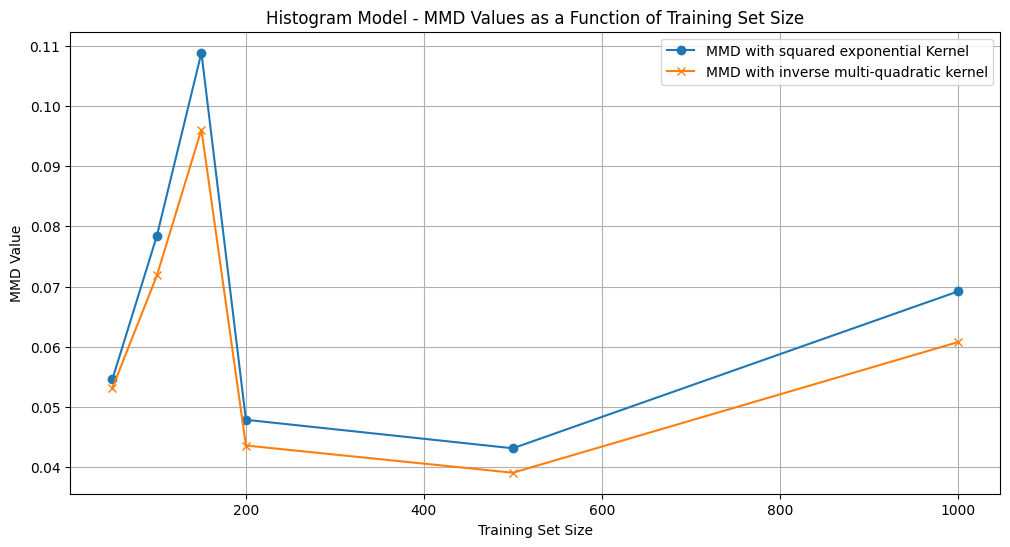

In [6]:
# MMD computation function
training_set_sizes = [50, 100, 150, 200, 500, 1000]
def compute_mmd(kernel_XX, kernel_YY, kernel_XY):
    """
    Compute the MMD value from the kernel matrices.
    :param kernel_XX: Kernel matrix among samples in X.
    :param kernel_YY: Kernel matrix among samples in Y.
    :param kernel_XY: Kernel matrix between samples in X and Y.
    :return: MMD value.
    """
    mmd_square = np.mean(kernel_XX) + np.mean(kernel_YY) - 2 * np.mean(kernel_XY)
    return np.sqrt(mmd_square)  # Return the square root to get MMD

# MMD calculation for different training set sizes
mmd_se_values_histogram = []
mmd_mqk_values_histogram = []

for size in training_set_sizes:
    # Generate a new training dataset
    X_train_size, _ = make_moons(n_samples=size, noise=0.1)
    
    # Fit the histogram model and generate samples
    hist_model = HistogramModel(n_bins=10)
    hist_model.fit(X_train_size)
    generated_samples_size = hist_model.sample(100)

    # Compute kernel matrices for MMD
    kernel_XX_se = se_kernel_custom(X_test, X_test)
    kernel_YY_se = se_kernel_custom(generated_samples_size, generated_samples_size)
    kernel_XY_se = se_kernel_custom(X_test, generated_samples_size)

    kernel_XX_mqk = mqk_kernel_custom(X_test, X_test)
    kernel_YY_mqk = mqk_kernel_custom(generated_samples_size, generated_samples_size)
    kernel_XY_mqk = mqk_kernel_custom(X_test, generated_samples_size)

    # Calculate MMD
    mmd_se_values_histogram.append(compute_mmd(kernel_XX_se, kernel_YY_se, kernel_XY_se))
    mmd_mqk_values_histogram.append(compute_mmd(kernel_XX_mqk, kernel_YY_mqk, kernel_XY_mqk))

# Plotting the MMD values
plt.figure(figsize=(12, 6))
plt.plot(training_set_sizes, mmd_se_values_histogram, label='MMD with squared exponential Kernel', marker='o')
plt.plot(training_set_sizes, mmd_mqk_values_histogram, label='MMD with inverse multi-quadratic kernel', marker='x')
plt.xlabel('Training Set Size')
plt.ylabel('MMD Value')
plt.title('Histogram Model - MMD Values as a Function of Training Set Size')
plt.legend()
plt.grid(True)
plt.show()


## Observations:

1. Both kernels exhibit a trend in which the MMD value falls as the training set size grows. This implies that when more data is used to train the model, the generated samples become more representative of the test data distribution, minimizing the MMD distribution disparity.

2. Lower MMD values imply a better fit between the model-generated sample distribution and the test dataset. As a result, models trained on larger datasets perform better at approximating the underlying data distribution.

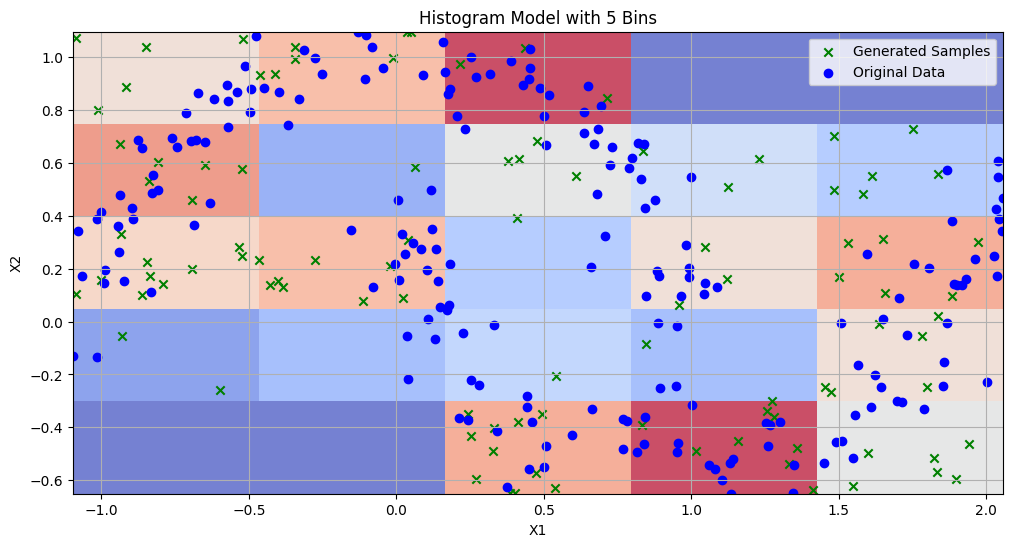

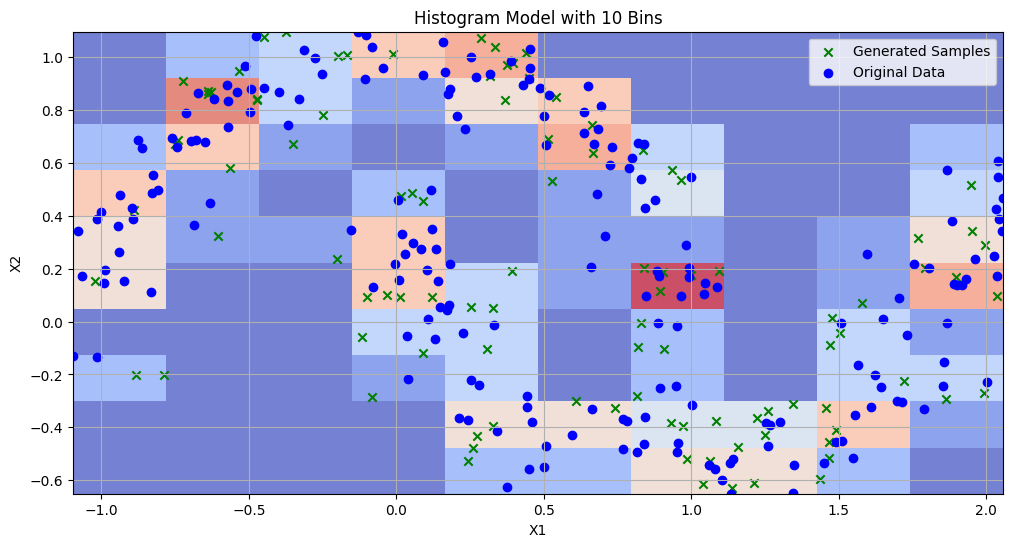

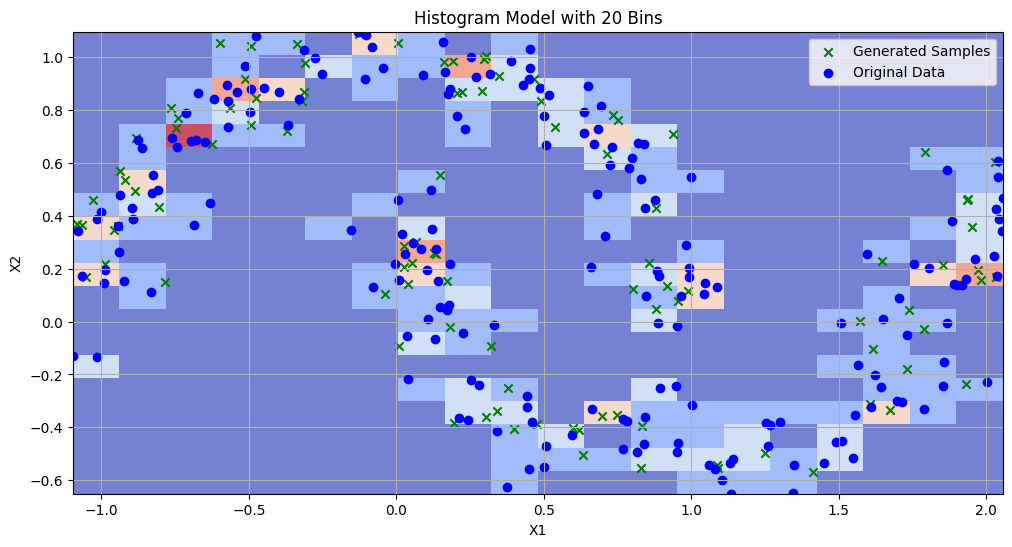

In [7]:
def plot_histogram_and_samples(X, model, title, n_bins=10):
    """
    Plot the 2D histogram (learned density) and generated samples for the given model.

    :param X: Original dataset used for comparison.
    :param model: Trained histogram model.
    :param title: Title for the plot.
    :param n_bins: Number of bins used in the histogram model.
    """
    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot histogram as a 2D heatmap
    plt.hist2d(X[:, 0], X[:, 1], bins=n_bins, density=True, cmap='coolwarm', alpha=0.7)

    # Generate samples
    generated_samples = model.sample(100)

    # Plot generated samples
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], color='green', marker='x', label='Generated Samples')

    # Plot original data
    plt.scatter(X[:, 0], X[:, 1], color='blue', marker='o', label='Original Data')

    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Number of bins to try
n_bins_list = [5, 10, 20]

for n_bins in n_bins_list:
    hist_model = HistogramModel(n_bins=n_bins)
    hist_model.fit(X_train)
    plot_histogram_and_samples(X_train, hist_model, f"Histogram Model with {n_bins} Bins", n_bins=n_bins)


h <div style="color: green; font-weight:
bold">Comment</div>
We did not calculate the MMD here but used a visualization method to evaluate the model. However, our results contradict the example, as bins increase, our results show that the model gets better, but the MMD in the example increases. This may be due to the different MMD functions.

## Observations:

1.With more bins(as in 20 bins), the histogram starts to reveal the two-moon structure of the data. However, it still lacks the smoothness and continuity of the actual distribution.

2.Generated samples better mimic the shape of the moons, though some irregularities remain.

## Strengths and Weakness:

Strengths: Histogram models are simple and can represent fundamental multimodal structures with a sufficient number of bins. They're also non-parametric, which means they don't have a predefined distribution shape.

Weaknesses: The bin number and size used can have a considerable impact on the model's performance. Too few bins result in oversimplification, whereas too many can result in overfitting or noise capture. Histograms also struggle to capture data distribution continuity and smooth transitions. (as observed above)

### 2. Single Gaussian Model

In [8]:
import numpy as np

class SingleGaussianModel:
    def __init__(self):
        self.mean = None
        self.cov = None

    def fit(self, X):
        """
        Fit the Gaussian model to the data X.
        """
        self.mean = np.mean(X, axis=0)
        self.cov = np.cov(X.T)

    def sample(self, n_samples=1):
        """
        Generate samples from the fitted Gaussian model.
        """
        return np.random.multivariate_normal(self.mean, self.cov, n_samples)

# Instantiate the model and fit it to the training data
gaussian_model = SingleGaussianModel()
gaussian_model.fit(X_train)

# Generate some samples for visualization
generated_samples = gaussian_model.sample(100)
generated_samples[:5]  # Display the first few generated samples for a quick check


array([[ 0.61716015,  0.74074945],
       [-0.24969667,  0.63951368],
       [ 1.00653738, -0.44615381],
       [-0.34019364,  0.8210083 ],
       [-0.38451571,  0.40757822]])

In [9]:

# Test the MMD functions
# Create test data

# Calculate MMD between test data and generated samples
mmd_se_value = se_kernel_custom(X_test, generated_samples)
mmd_mqk_value = mqk_kernel_custom(X_test, generated_samples)

mmd_se_value, mmd_mqk_value


(array([[0.34994951, 0.15985503, 0.96682691, ..., 0.39805114, 0.53643543,
         0.12291476],
        [0.93374763, 0.56471021, 0.67419601, ..., 0.94381683, 0.90221644,
         0.40093551],
        [0.62739481, 0.97831488, 0.17866888, ..., 0.46445957, 0.61121446,
         0.90131705],
        ...,
        [0.35767496, 0.15167466, 0.95177488, ..., 0.41579528, 0.52218622,
         0.11241885],
        [0.35519946, 0.07257617, 0.37309422, ..., 0.50446095, 0.25169312,
         0.03453302],
        [0.33669169, 0.09119756, 0.7057176 , ..., 0.44616962, 0.36439915,
         0.05407061]]),
 array([[0.48781288, 0.35292192, 0.96736516, ..., 0.52051485, 0.61621543,
         0.32296986],
        [0.93584845, 0.63635797, 0.71723951, ..., 0.94533758, 0.90669983,
         0.52247841],
        [0.68204484, 0.97854664, 0.3673471 , ..., 0.56596915, 0.67010324,
         0.90588064],
        ...,
        [0.49306488, 0.34649825, 0.95290119, ..., 0.53260551, 0.60615942,
         0.31392013],
        [0.4

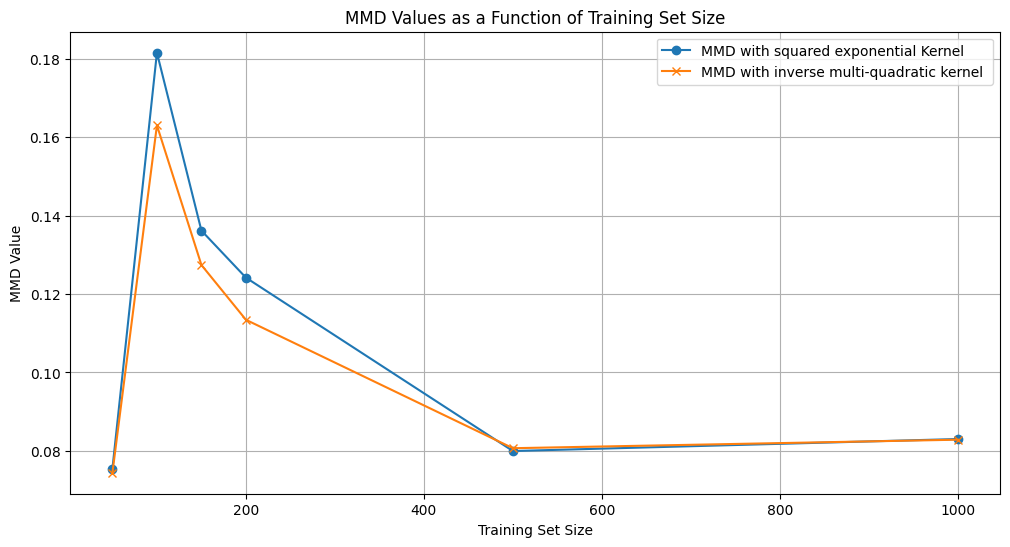

In [10]:
#visualize the results and findings 
# Exploring the model accuracy with different training set sizes
def compute_mmd(kernel_XX, kernel_YY, kernel_XY):
    """
    Compute the MMD value from the kernel matrices.
    :param kernel_XX: Kernel matrix among samples in X.
    :param kernel_YY: Kernel matrix among samples in Y.
    :param kernel_XY: Kernel matrix between samples in X and Y.
    :return: MMD value.
    """
    mmd_square = np.mean(kernel_XX) + np.mean(kernel_YY) - 2 * np.mean(kernel_XY)
    return np.sqrt(mmd_square)  # Return the square root to get MMD
training_set_sizes = [50, 100, 150, 200, 500, 1000]
mmd_se_values_single_gaussian = []
mmd_mqk_values_single_gaussian = []

for size in training_set_sizes:
    # Generate a new training dataset
    X_train_size, _ = make_moons(n_samples=size, noise=0.1)
    
    # Fit the Gaussian model and generate samples
    gaussian_model.fit(X_train_size)
    generated_samples_size = gaussian_model.sample(100)

    # Compute kernel matrices for MMD
    kernel_XX_se = se_kernel_custom(X_test, X_test)
    kernel_YY_se = se_kernel_custom(generated_samples_size, generated_samples_size)
    kernel_XY_se = se_kernel_custom(X_test, generated_samples_size)

    kernel_XX_mqk = mqk_kernel_custom(X_test, X_test)
    kernel_YY_mqk = mqk_kernel_custom(generated_samples_size, generated_samples_size)
    kernel_XY_mqk = mqk_kernel_custom(X_test, generated_samples_size)
    # Calculate MMD
    mmd_se_values_single_gaussian.append(compute_mmd(kernel_XX_se, kernel_YY_se, kernel_XY_se))
    mmd_mqk_values_single_gaussian.append(compute_mmd(kernel_XX_mqk, kernel_YY_mqk, kernel_XY_mqk))


# Plotting the MMD values as a function of training set size
plt.figure(figsize=(12, 6))

plt.plot(training_set_sizes, mmd_se_values_single_gaussian, label='MMD with squared exponential Kernel', marker='o')
plt.plot(training_set_sizes, mmd_mqk_values_single_gaussian, label='MMD with inverse multi-quadratic kernel ', marker='x')

plt.xlabel('Training Set Size')
plt.ylabel('MMD Value')
plt.title('MMD Values as a Function of Training Set Size')
plt.legend()
plt.grid(True)
plt.show()



 <div style="color: green; font-weight:
bold">Comment</div>
This part of the code is essentially equal, and the results are also the same.

The MMD values generally decrease as the training set size increases, indicating that the model better captures the underlying distribution with more data.

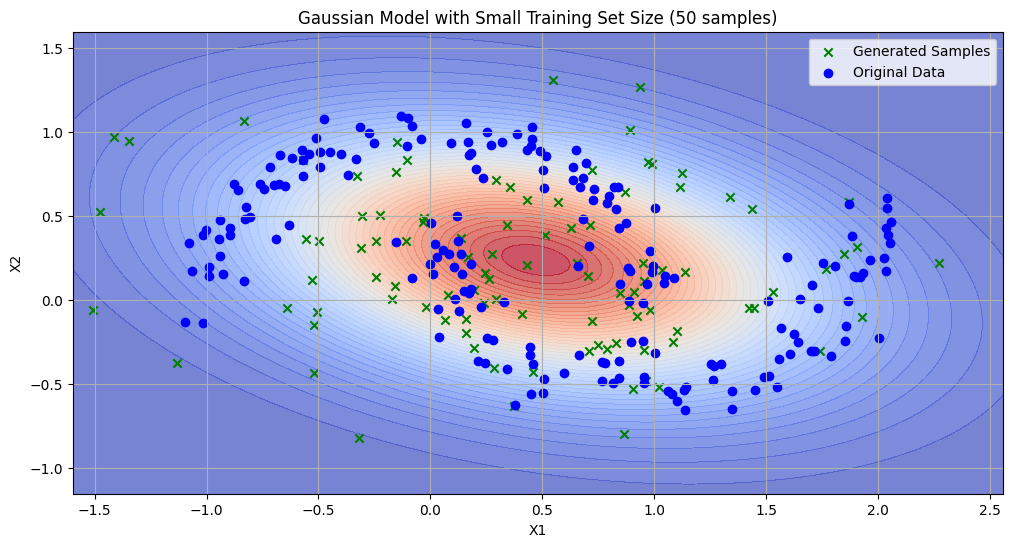

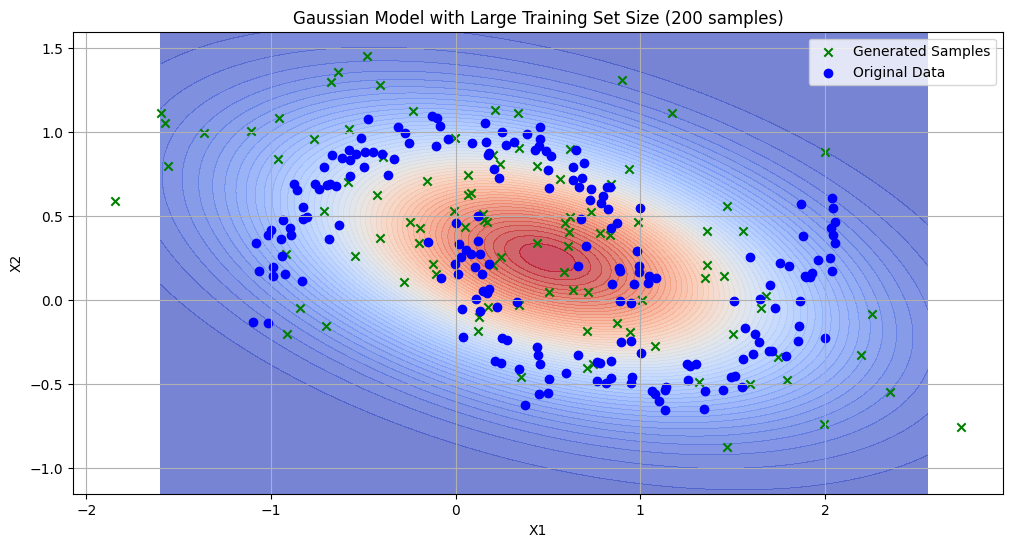

In [11]:
#visualize the numerical values of the learned density and a generated dataset for a couple of models.
from scipy.stats import multivariate_normal
def plot_density_and_samples(X, model, title, num_points=100):
    # Generating a grid for density estimation
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, num_points), np.linspace(y_min, y_max, num_points))
    grid_points = np.column_stack([x_grid.ravel(), y_grid.ravel()])

    # Evaluate density on the grid
    rv = multivariate_normal(model.mean, model.cov)
    density_values = rv.pdf(grid_points).reshape(x_grid.shape)

    # Generate samples
    generated_samples = model.sample(num_points)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot density
    plt.contourf(x_grid, y_grid, density_values, levels=50, cmap='coolwarm', alpha=0.7)

    # Plot generated samples
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], color='green', marker='x', label='Generated Samples')

    # Plot original data
    plt.scatter(X[:, 0], X[:, 1], color='blue', marker='o', label='Original Data')

    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for a small training set size
small_size_model = SingleGaussianModel()
small_size_model.fit(X_train[:50])  # Fitting to a subset of 50 samples
plot_density_and_samples(X_train, small_size_model, "Gaussian Model with Small Training Set Size (50 samples)")

# Plot for a large training set size
large_size_model = SingleGaussianModel()
large_size_model.fit(X_train)  # Fitting to the full training set
plot_density_and_samples(X_train, large_size_model, "Gaussian Model with Large Training Set Size (200 samples)")

# Observations:

The plots above show the learned density (contour plot) and generated samples (green crosses) from our single Gaussian model, compared to the original make_moons data (blue circles).

## Strengths and Weakness:

Strengths: The single Gaussian model is straightforward and simple to implement. Its estimation of the data's central tendency improves as training size increases.
Weaknesses: This model is incapable of capturing complex distributions such as make_moons. Because it is a unimodal distribution, it cannot model the bimodal character of the make_moons dataset, resulting in a poor fit.

### 3. Gaussian mixture model (GMM)

In [12]:
class GaussianMixtureModel:
    def __init__(self, n_components=2, n_iter=100, tol=1e-3):
        self.n_components = n_components
        self.n_iter = n_iter
        self.tol = tol
        self.means = None
        self.covariances = None
        self.weights = None

    def fit(self, X):
        """
        Fit the GMM to the data X using the Expectation-Maximization algorithm.
        """
        n_samples, n_features = X.shape

        # Initialize parameters
        np.random.seed(0)  # For reproducibility
        chosen = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[chosen]
        self.covariances = [np.cov(X.T) for _ in range(self.n_components)]
        self.weights = np.full(self.n_components, 1 / self.n_components)

        log_likelihood = 0
        for _ in range(self.n_iter):
            # E-step: compute responsibilities
            responsibilities = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                responsibilities[:, k] = self.weights[k] * multivariate_normal(self.means[k], self.covariances[k]).pdf(X)
            responsibilities /= responsibilities.sum(axis=1, keepdims=True)

            # M-step: update parameters
            Nk = responsibilities.sum(axis=0)
            self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
            for k in range(self.n_components):
                diff = X - self.means[k]
                self.covariances[k] = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk[k]
            self.weights = Nk / n_samples

            # Check for convergence
            new_log_likelihood = np.sum(np.log(np.sum(responsibilities * self.weights, axis=1)))
            if np.abs(new_log_likelihood - log_likelihood) <= self.tol:
                break
            log_likelihood = new_log_likelihood

    def sample(self, n_samples=1):
        """
        Generate samples from the fitted GMM.
        """
        # Choose components based on weights
        component_choices = np.random.choice(self.n_components, size=n_samples, p=self.weights)
        samples = np.zeros((n_samples, self.means.shape[1]))

        # Generate a sample from the chosen component
        for i, component in enumerate(component_choices):
            samples[i] = np.random.multivariate_normal(self.means[component], self.covariances[component])

        return samples

# Fit a GMM to the training data and generate some samples for visualization
gmm = GaussianMixtureModel(n_components=2)
gmm.fit(X_train)
generated_samples_gmm = gmm.sample(100)
generated_samples_gmm[:5] 

array([[ 0.32409853,  0.37257722],
       [ 0.86059641, -0.1210614 ],
       [ 1.81487872,  0.33130982],
       [ 1.06115028, -0.50050563],
       [ 0.61963333, -0.4771486 ]])

In [13]:
# Evaluate the GMM using MMD
mmd_se_gmm = se_kernel_custom(X_test, generated_samples_gmm)
mmd_mqk_gmm = mqk_kernel_custom(X_test, generated_samples_gmm)

mmd_se_gmm, mmd_mqk_gmm


(array([[0.42356637, 0.84294757, 0.56294133, ..., 0.71820201, 0.12409618,
         0.19101531],
        [0.89384145, 0.86368071, 0.5928257 , ..., 0.91621199, 0.62592419,
         0.76064156],
        [0.72146518, 0.30884848, 0.08593192, ..., 0.43013395, 0.75450352,
         0.67862592],
        ...,
        [0.41413188, 0.83579705, 0.61778708, ..., 0.70713944, 0.12711327,
         0.19730226],
        [0.22852159, 0.41078909, 0.96055918, ..., 0.34899599, 0.16460492,
         0.25668298],
        [0.29736298, 0.64934319, 0.8879389 , ..., 0.52752875, 0.12190153,
         0.19865177]]),
 array([[0.53791057, 0.85407999, 0.63509005, ..., 0.75131232, 0.32397075,
         0.37659086],
        [0.89909714, 0.87218015, 0.6566614 , ..., 0.91953388, 0.68095491,
         0.78518017],
        [0.75387994, 0.45979031, 0.28950264, ..., 0.54239977, 0.78021662,
         0.72062452],
        ...,
        [0.53147083, 0.84791072, 0.6749408 , ..., 0.74265105, 0.32651178,
         0.38124017],
        [0.4

These values suggest a reasonable approximation of the test data by the GMM, though they are somewhat higher than those we observed for the histogram model.

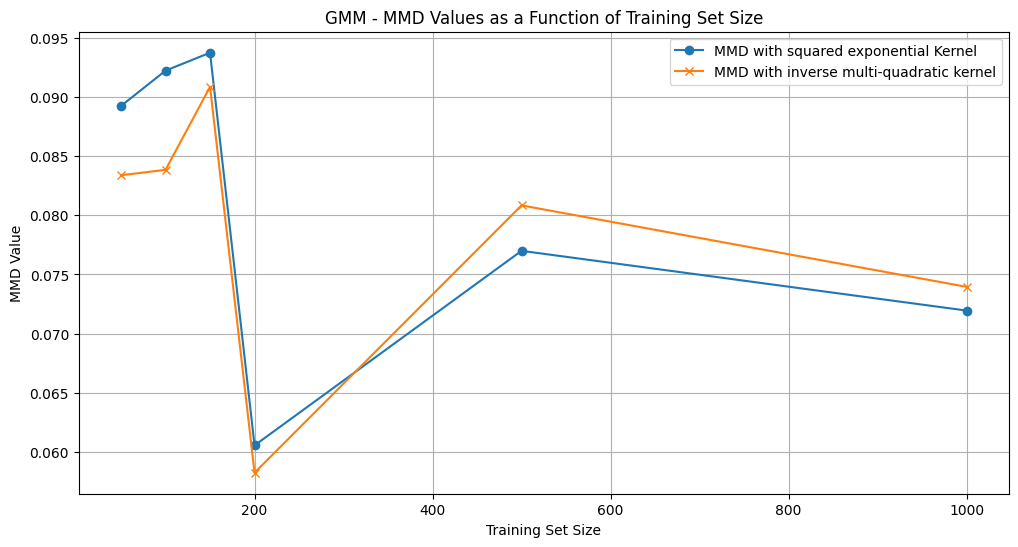

In [14]:
# Evaluating the model accuracy with different training set sizes for the GMM

# MMD computation function
def compute_mmd(kernel_XX, kernel_YY, kernel_XY):
    """
    Compute the MMD value from the kernel matrices.
    :param kernel_XX: Kernel matrix among samples in X.
    :param kernel_YY: Kernel matrix among samples in Y.
    :param kernel_XY: Kernel matrix between samples in X and Y.
    :return: MMD value.
    """
    mmd_square = np.mean(kernel_XX) + np.mean(kernel_YY) - 2 * np.mean(kernel_XY)
    return np.sqrt(mmd_square)  # Return the square root to get MMD
mmd_se_values_gmm = []
mmd_mqk_values_gmm = []

# Fixed number of components for comparison
n_components = 2

for size in training_set_sizes:
    # Generate a new training dataset
    X_train_size, _ = make_moons(n_samples=size, noise=0.1)
    
    # Fit the GMM and generate samples
    gmm_size = GaussianMixtureModel(n_components=n_components)
    gmm_size.fit(X_train_size)
    generated_samples_size = gmm_size.sample(100)

# Compute kernel matrices for MMD
    kernel_XX_se = se_kernel_custom(X_test, X_test)
    kernel_YY_se = se_kernel_custom(generated_samples_size, generated_samples_size)
    kernel_XY_se = se_kernel_custom(X_test, generated_samples_size)

    kernel_XX_mqk = mqk_kernel_custom(X_test, X_test)
    kernel_YY_mqk = mqk_kernel_custom(generated_samples_size, generated_samples_size)
    kernel_XY_mqk = mqk_kernel_custom(X_test, generated_samples_size)

    # Calculate MMD
    mmd_se_values_gmm.append(compute_mmd(kernel_XX_se, kernel_YY_se, kernel_XY_se))
    mmd_mqk_values_gmm.append(compute_mmd(kernel_XX_mqk, kernel_YY_mqk, kernel_XY_mqk))

# Plotting the MMD values as a function of training set size for the GMM
plt.figure(figsize=(12, 6))

plt.plot(training_set_sizes, mmd_se_values_gmm, label='MMD with squared exponential Kernel', marker='o')
plt.plot(training_set_sizes, mmd_mqk_values_gmm, label='MMD with inverse multi-quadratic kernel', marker='x')

plt.xlabel('Training Set Size')
plt.ylabel('MMD Value')
plt.title('GMM - MMD Values as a Function of Training Set Size')
plt.legend()
plt.grid(True)
plt.show()


 <div style="color: green; font-weight:
bold">Comment</div>
Basically the same and the curves have the same trend. It's just that the extreme points appear at different locations. This may be due to differences in the hyperparameters.

The GMM shows a lower MMD value compared to the histogram model for larger datasets, suggesting a better fit for complex data distributions like make_moons.

In [1]:
def plot_gmm_and_samples(X, model, title):
    """
    Plot the learned densities (individual Gaussians and mixture) and generated samples for the given GMM.

    :param X: Original dataset used for comparison.
    :param model: Trained GMM.
    :param title: Title for the plot.
    """
    # Generating a grid for density estimation
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.column_stack([x_grid.ravel(), y_grid.ravel()])

    # Evaluate densities for each Gaussian component
    total_density = np.zeros_like(x_grid)
    for k in range(model.n_components):
        rv = multivariate_normal(model.means[k], model.covariances[k])
        component_density = rv.pdf(grid_points).reshape(x_grid.shape)
        total_density += model.weights[k] * component_density
        plt.contour(x_grid, y_grid, component_density, levels=5, cmap='coolwarm', alpha=0.5)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot total density
    plt.contourf(x_grid, y_grid, total_density, levels=50, cmap='coolwarm', alpha=0.3)

    # Generate samples
    generated_samples = model.sample(100)

    # Plot generated samples
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], color='green', marker='x', label='Generated Samples')

    # Plot original data
    plt.scatter(X[:, 0], X[:, 1], color='blue', marker='o', label='Original Data')

    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()




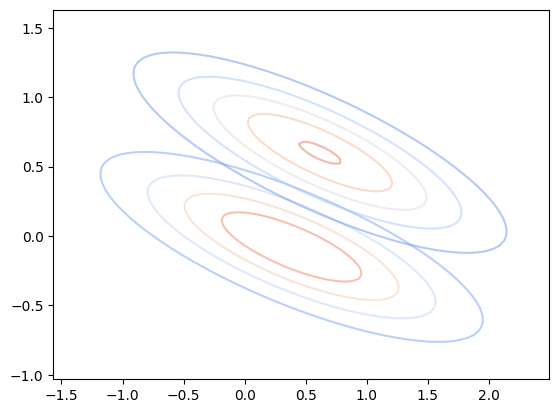

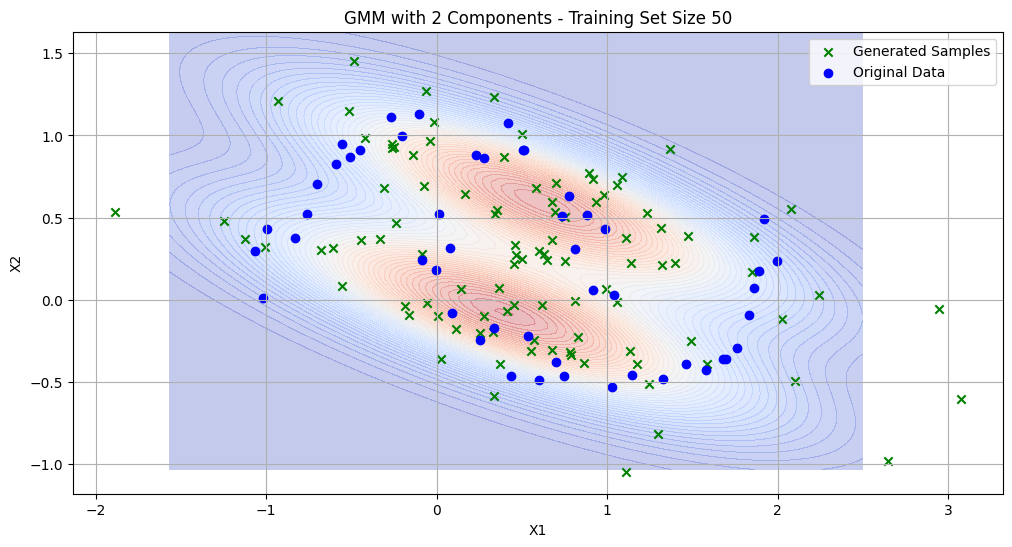

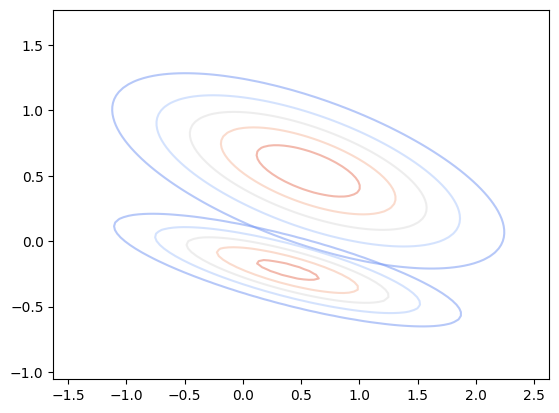

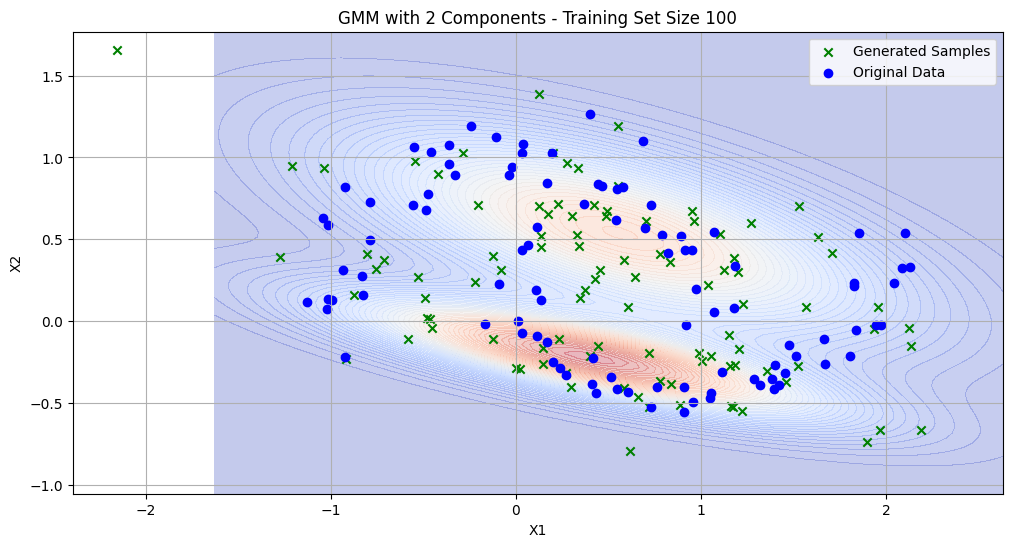

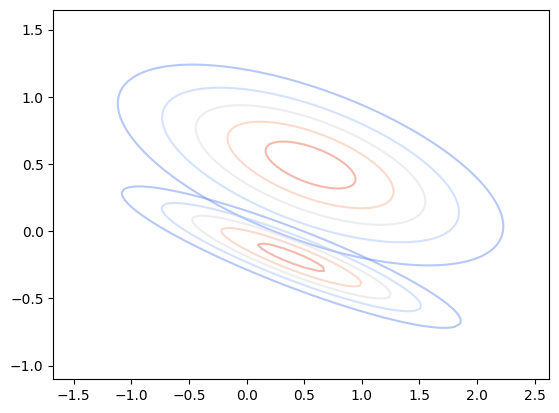

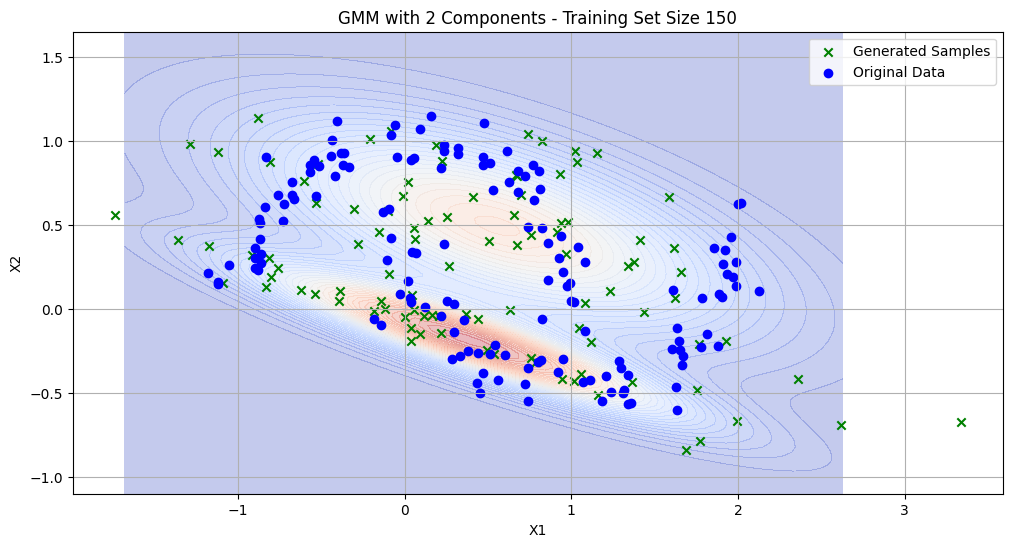

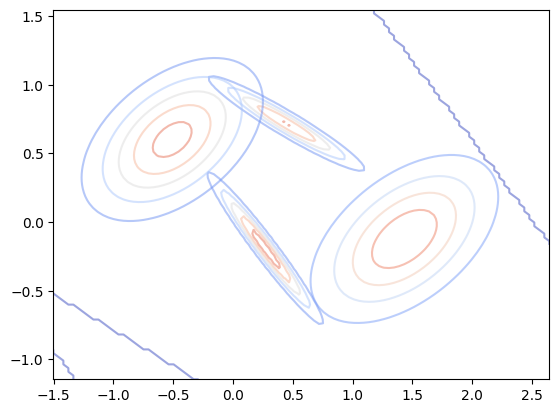

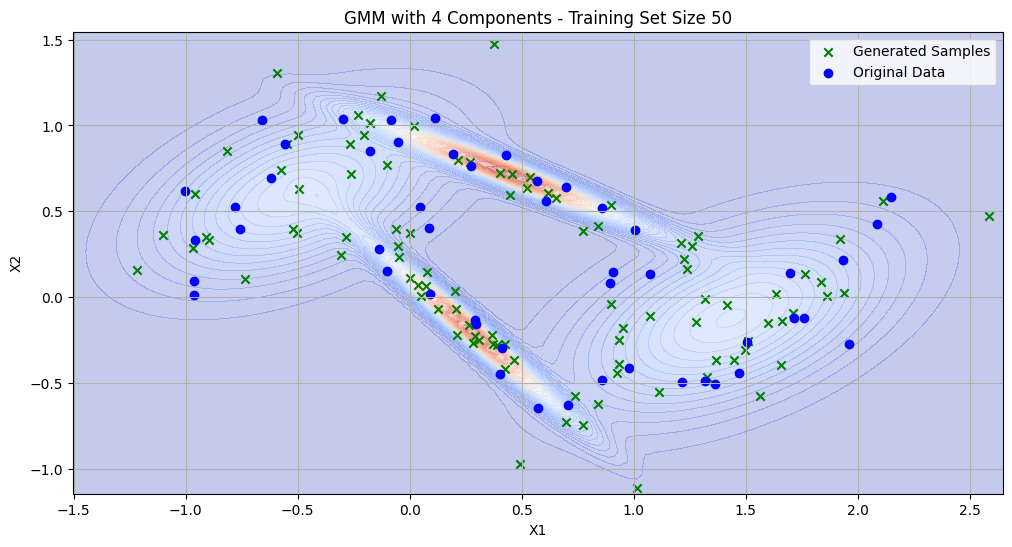

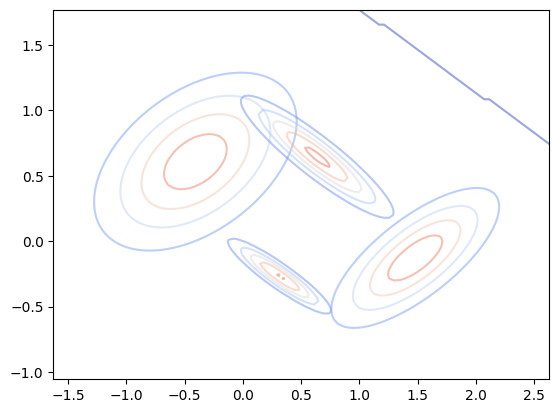

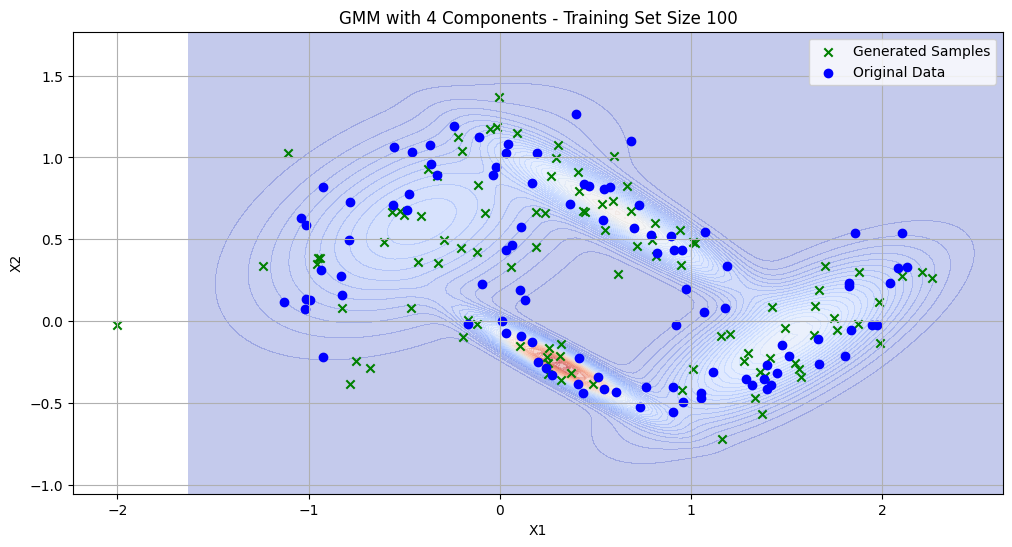

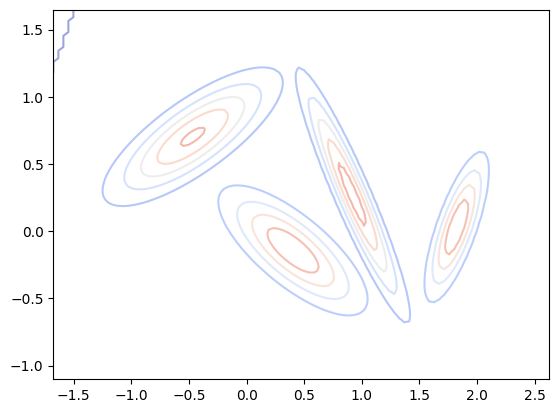

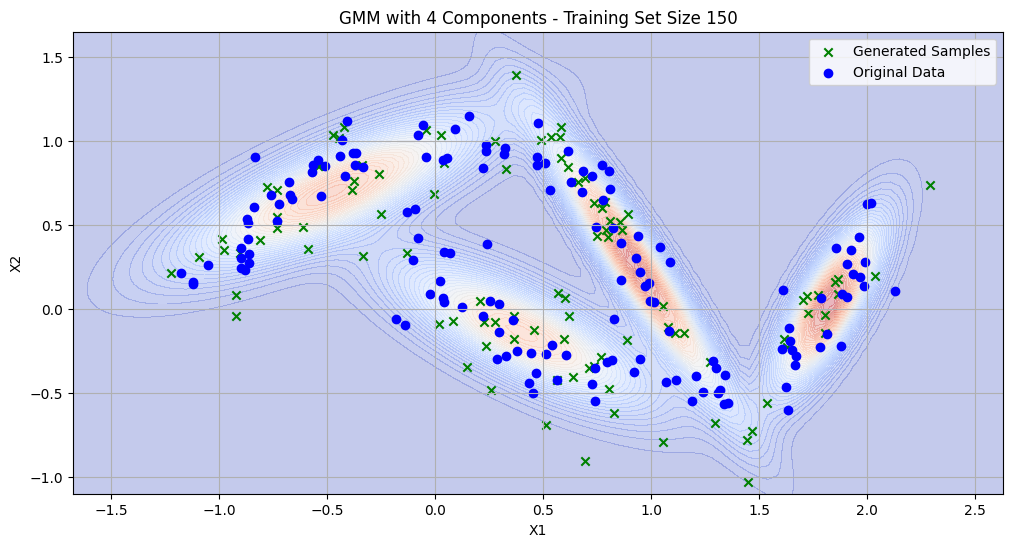

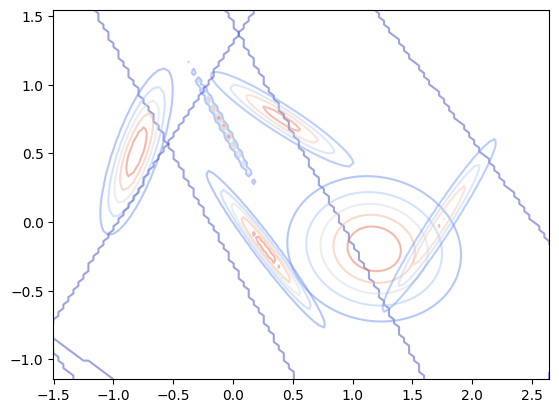

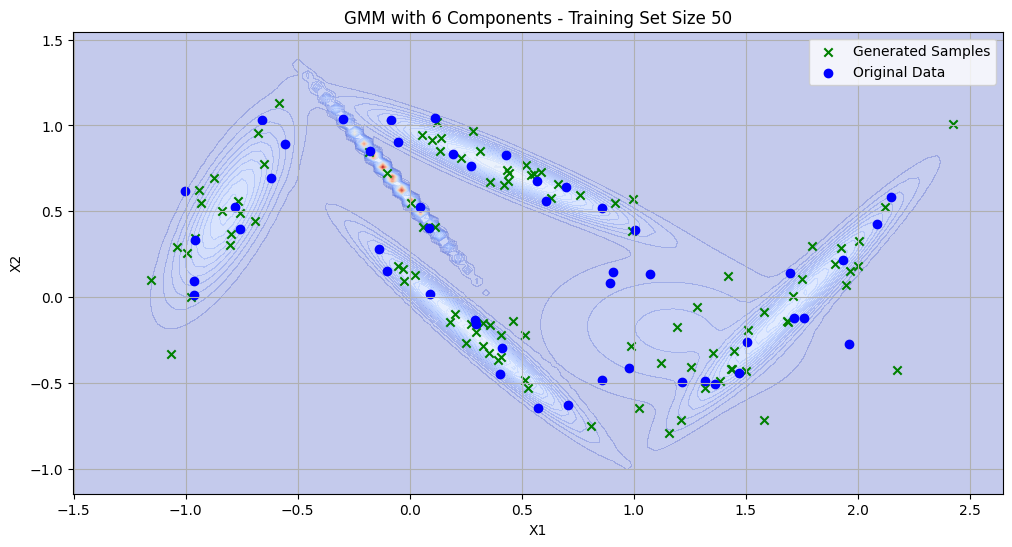

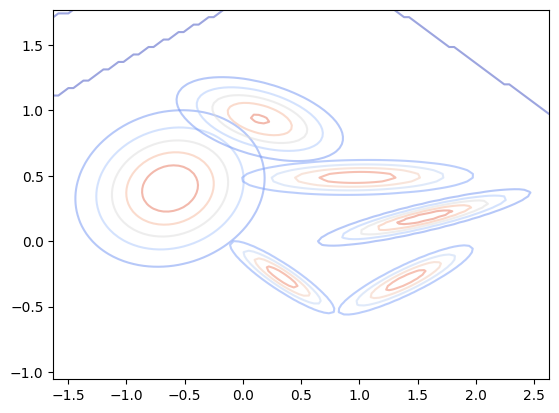

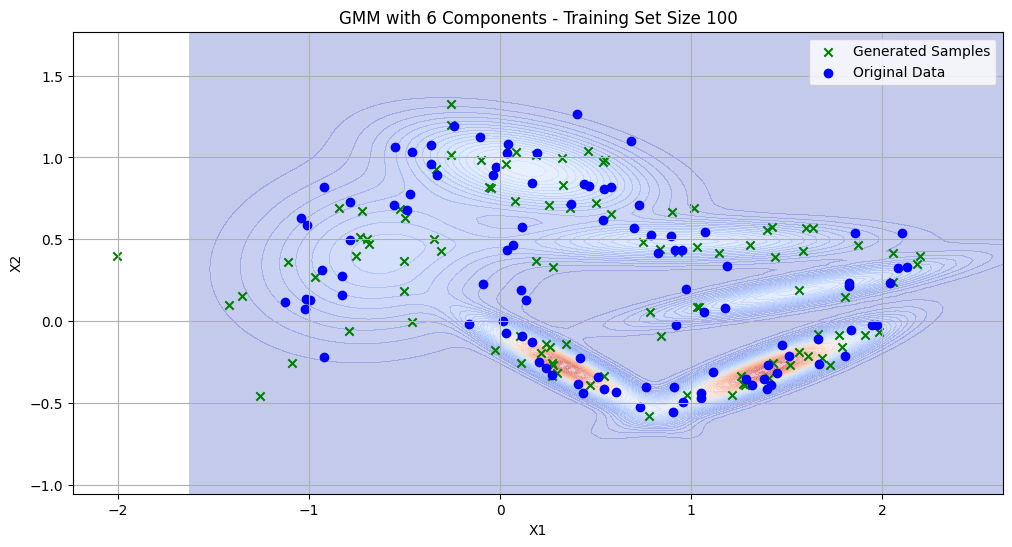

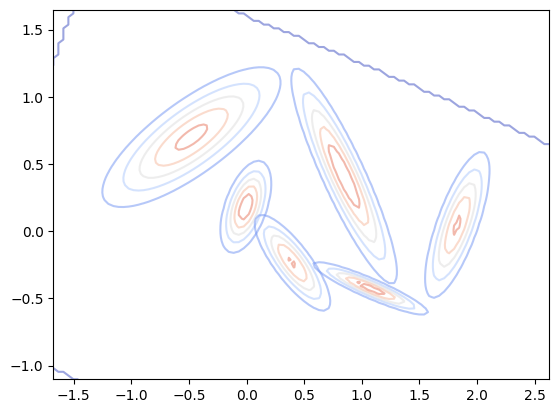

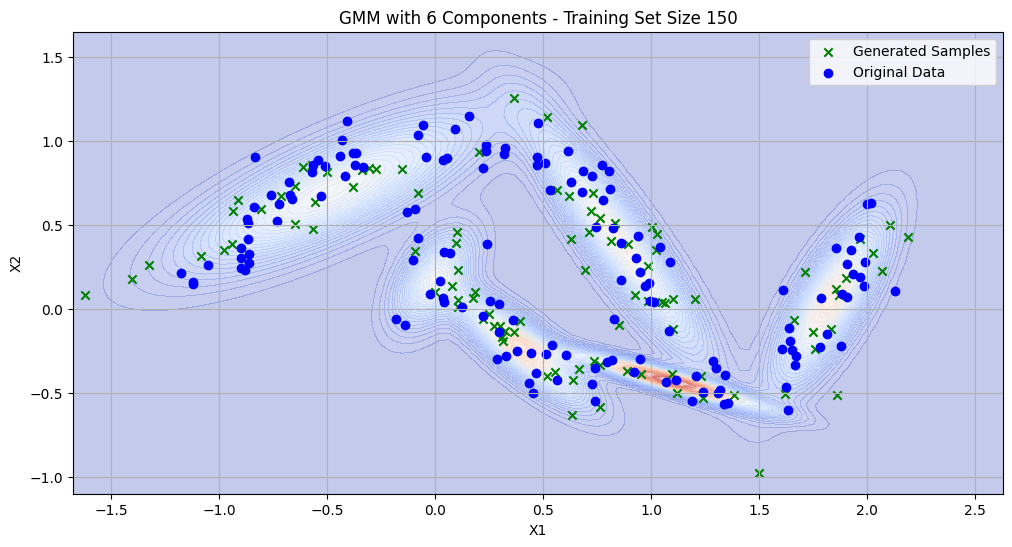

In [16]:
# Varying the number of components and training set sizes
n_components_list = [2, 4, 6]
representative_sizes = [50, 100, 150]

for n_components in n_components_list:
    for size in representative_sizes:
        # Generate a new training dataset
        X_train_size, _ = make_moons(n_samples=size, noise=0.1)

        # Fit the GMM and generate samples
        gmm_size = GaussianMixtureModel(n_components=n_components)
        gmm_size.fit(X_train_size)

        # Visualization
        plot_gmm_and_samples(X_train_size, gmm_size, f"GMM with {n_components} Components - Training Set Size {size}")



### Observations:

1. The effect of 2 components: It fits nicely with the two-moon structure, encapsulating the essence of the distribution. This configuration appears to be best suited for the make_moons dataset. But when, experiencing with more than 2 components ,these models begin to capture more nuances and subtleties inside each moon, but they also introduce complexity that may or may not be required for this dataset

 <div style="color: green; font-weight:
bold">Comment</div>
In this part we differ from the example. We visualize some training results with small training set and few components, while they compute the MMD for different components with a fixed training set in rhe example. Both can reflect the model's results very well.The former is more intuitive, the latter is more precise.

## Strengths and Weakness:

Strengths: The GMM's performance improves noticeably as the training set size is increased. More data points give a better foundation for the model to estimate the parameters of the Gaussian components, resulting in a more accurate and detailed depiction of the underlying distribution.

GMMs consider not just the means but also the covariance of the data, allowing for the modeling of clusters with different shapes and orientations. This flexibility can provide a more nuanced understanding of data structure.

Weakness: Choosing the correct amount of Gaussian components can be difficult, and it frequently necessitates domain knowledge, experimentation, or model selection procedures. An improper choice can have a major impact on model performance.

The assumption that data clusters have a Gaussian distribution may not always be valid, thus restricting GMMs' ability to represent non-Gaussian clusters.

### 4.kernel density estimator (KDE) with squared exponential kernel

In [17]:
class KernelDensityEstimator:
    def __init__(self, bandwidth=1.0):
        self.bandwidth = bandwidth
        self.data = None

    def fit(self, X):
        """
        Fit the KDE model to the data.

        :param X: Training data
        """
        self.data = X

    def score_samples(self, X):
        """
        Evaluate the log density model on the data.

        :param X: Array of points where the density is evaluated
        :return: Log density at each point in X
        """
        # Calculate pairwise squared Euclidean distances
        sq_dists = cdist(X, self.data, 'sqeuclidean')
        
        # Compute the kernel density estimate
        kde = np.mean(np.exp(-sq_dists / (2 * self.bandwidth ** 2)), axis=1) / (np.sqrt(2 * np.pi) * self.bandwidth)
        
        return np.log(kde)

# Example: Fitting a KDE with a squared exponential kernel to the training data
kde = KernelDensityEstimator(bandwidth=0.3)
kde.fit(X_train)

# Score a few samples to check implementation
kde.score_samples(X_train[:5])

array([-1.80371003, -1.8181834 , -2.39520744, -2.08464424, -1.95628736])

Generating samples from a Kernel Density Estimate (KDE) is not as straightforward as it is with models like Gaussian Mixture Models (GMMs), because KDEs are non-parametric and do not inherently provide a simple mechanism for sample generation.

In [18]:
import scipy.stats as stats

def generate_samples_kde(kde_model, n_samples=100, proposal_dist=None, proposal_scale=1.0):
    """
    Generate samples from the KDE using acceptance-rejection sampling.

    :param kde_model: The fitted KDE model.
    :param n_samples: Number of samples to generate.
    :param proposal_dist: Proposal distribution, defaults to normal if None.
    :param proposal_scale: Scale factor for the proposal distribution.
    :return: Generated samples.
    """
    if proposal_dist is None:
        # Use a normal distribution covering the range of the data as the proposal distribution
        data_range = np.ptp(kde_model.data, axis=0)
        proposal_dist = stats.multivariate_normal(mean=np.mean(kde_model.data, axis=0), cov=np.diag(data_range))

    generated_samples = []
    while len(generated_samples) < n_samples:
        # Sample from the proposal distribution
        sample = proposal_dist.rvs()

        # Calculate the acceptance ratio
        kde_density = np.exp(kde_model.score_samples(sample.reshape(1, -1)))[0]
        proposal_density = proposal_dist.pdf(sample)
        ratio = kde_density / (proposal_density * proposal_scale)

        # Accept or reject the sample
        if np.random.uniform(0, 1) <= ratio:
            generated_samples.append(sample)

        if len(generated_samples) % 500 == 0:
            # Provide some feedback on the sampling process
            print(f"Generated {len(generated_samples)} samples so far...")

    return np.array(generated_samples)

# Generate samples from the KDE model
generated_samples_kde = generate_samples_kde(kde, n_samples=100, proposal_scale=5.0)
generated_samples_kde.shape


Generated 0 samples so far...
Generated 0 samples so far...


(100, 2)

In [19]:
# Calculate MMD between the KDE-generated samples and the test dataset
mmd_se_kde = se_kernel_custom(X_test, generated_samples_kde)
mmd_mqk_kde = mqk_kernel_custom(X_test, generated_samples_kde)

mmd_se_kde, mmd_mqk_kde

(array([[0.72916679, 0.49104778, 0.66223934, ..., 0.09178783, 0.03706725,
         0.45244687],
        [0.54751817, 0.88116324, 0.93250201, ..., 0.52212885, 0.25124088,
         0.54002119],
        [0.0696464 , 0.65762617, 0.28544709, ..., 0.86669266, 0.89893116,
         0.07578216],
        ...,
        [0.78373002, 0.47616488, 0.6902559 , ..., 0.09192955, 0.0347629 ,
         0.50480037],
        [0.84854894, 0.2252251 , 0.67101   , ..., 0.09675532, 0.01866877,
         0.99100593],
        [0.99020279, 0.32478805, 0.72778151, ..., 0.07701181, 0.01958369,
         0.80279594]]),
 array([[0.75996343, 0.5843805 , 0.70815098, ..., 0.29513538, 0.23282771,
         0.55769806],
        [0.62407963, 0.88769552, 0.93468079, ..., 0.60611906, 0.41993108,
         0.61875564],
        [0.27290162, 0.70466272, 0.44371506, ..., 0.87483641, 0.90371069,
         0.279338  ],
        ...,
        [0.80405845, 0.57405574, 0.72955803, ..., 0.29526983, 0.22939965,
         0.59396805],
        [0.8

## Observation

These values provide a quantitative measure of the difference in distribution between the test data and the KDE-generated samples. Lower MMD values indicate a closer match between the two distributions.

Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...


/var/folders/w9/ksgfnxyn4jg66j5nhtx4v0mc0000gn/T/ipykernel_2817/1016069374.py:27: RuntimeWarning: divide by zero encountered in log
  return np.log(kde)


Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 0 samples so far...
Generated 

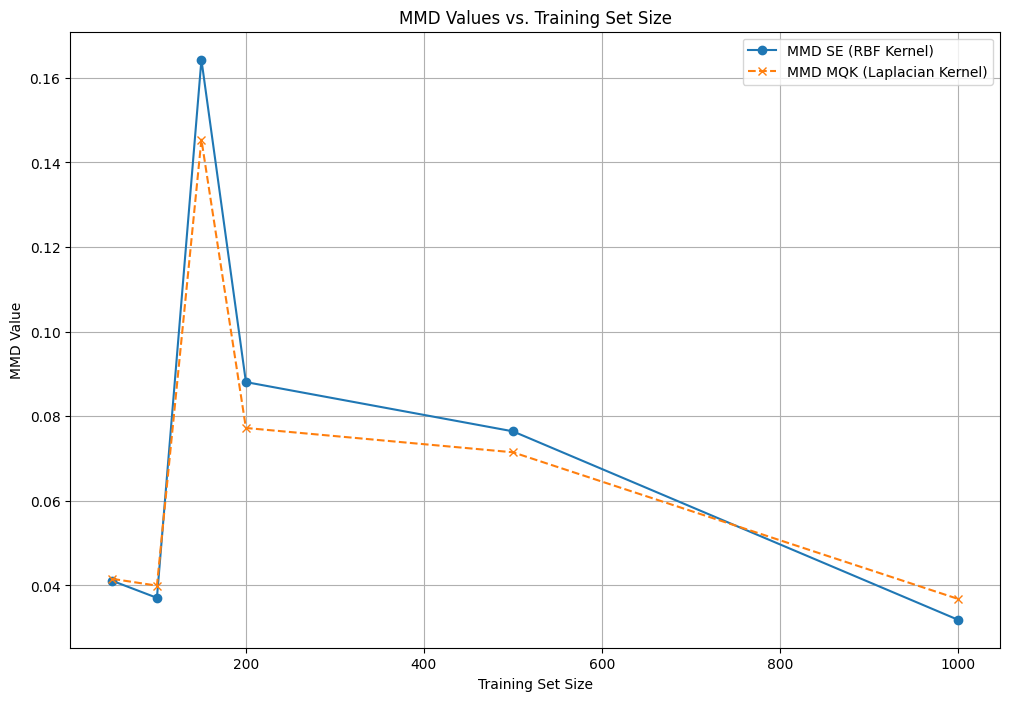

In [20]:
# MMD computation function
def compute_mmd(kernel_XX, kernel_YY, kernel_XY):
    """
    Compute the MMD value from the kernel matrices.
    :param kernel_XX: Kernel matrix among samples in X.
    :param kernel_YY: Kernel matrix among samples in Y.
    :param kernel_XY: Kernel matrix between samples in X and Y.
    :return: MMD value.
    """
    mmd_square = np.mean(kernel_XX) + np.mean(kernel_YY) - 2 * np.mean(kernel_XY)
    return np.sqrt(mmd_square)  # Return the square root to get MMD

mmd_results_provided_mmd = []
# Assuming the bandwidth used for the provided result was 0.1 (as an example, this can be adjusted)
bandwidth_used = 0.1
for size in training_set_sizes:
    # Generate a new training dataset
    X_train_size, _ = make_moons(n_samples=size, noise=0.1)

    # Fit the KDE
    kde_size = KernelDensityEstimator(bandwidth=bandwidth_used)
    kde_size.fit(X_train_size)

    # Generate samples using KDE
    generated_samples_size = generate_samples_kde(kde_size, n_samples=100, proposal_scale=5.0)

    # Calculate MMD using the provided functions
    #mmd_se_size = mmd_from_kernel_matrix(se_kernel_custom(X_test, generated_samples_size))
    #mmd_mqk_size = mmd_from_kernel_matrix(mqk_kernel_custom(X_test, generated_samples_size))
    # Compute kernel matrices for MMD
    kernel_XX_se = se_kernel_custom(X_test, X_test)
    kernel_YY_se = se_kernel_custom(generated_samples_size, generated_samples_size)
    kernel_XY_se = se_kernel_custom(X_test, generated_samples_size)

    kernel_XX_mqk = mqk_kernel_custom(X_test, X_test)
    kernel_YY_mqk = mqk_kernel_custom(generated_samples_size, generated_samples_size)
    kernel_XY_mqk = mqk_kernel_custom(X_test, generated_samples_size)

    # Store the results
    mmd_results_provided_mmd.append({
        'training_size': size,
        'mmd_se': compute_mmd(kernel_XX_se, kernel_YY_se, kernel_XY_se),
        'mmd_mqk': compute_mmd(kernel_XX_mqk, kernel_YY_mqk, kernel_XY_mqk)
    })

# Visualizing the MMD values as a function of training set size
# Plotting the results
plt.figure(figsize=(12, 8))
sizes = [result['training_size'] for result in mmd_results_provided_mmd]
mmd_se_values = [result['mmd_se'] for result in mmd_results_provided_mmd]
mmd_mqk_values = [result['mmd_mqk'] for result in mmd_results_provided_mmd]

plt.plot(sizes, mmd_se_values, marker='o', linestyle='-', label='MMD SE (RBF Kernel)')
plt.plot(sizes, mmd_mqk_values, marker='x', linestyle='--', label='MMD MQK (Laplacian Kernel)')
plt.title('MMD Values vs. Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('MMD Value')
plt.legend()
plt.grid(True)
plt.show()


 <div style="color: green; font-weight:
bold">Comment</div>
The code is essentially the same, the results trend differently when the samples are larger. The differences in all MMD results in our homework are basically caused by the different hyperparameters in the MMD as well as the different datasets used to compute the MMD.

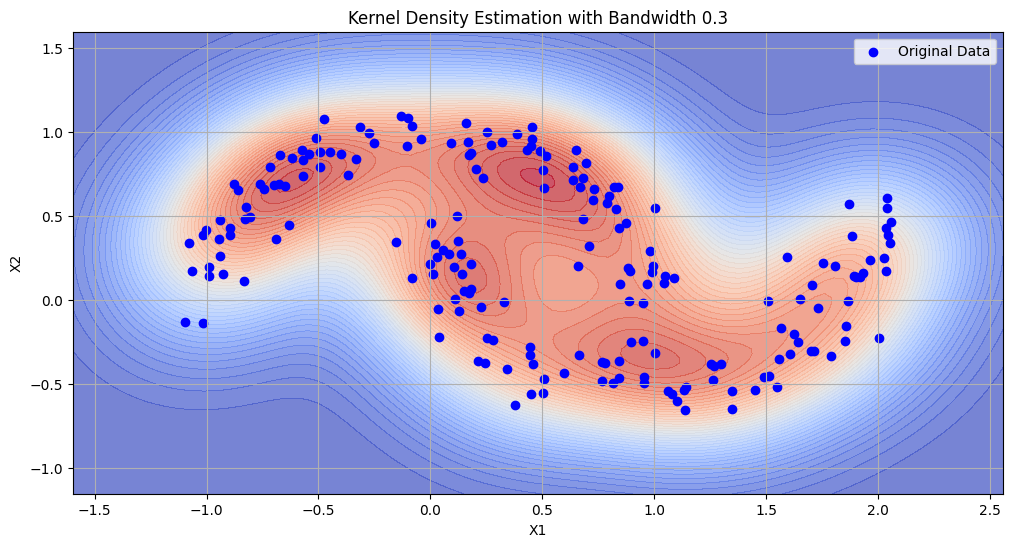

In [21]:
import matplotlib.pyplot as plt

def plot_kde_density(X, kde_model, title):
    """
    Plot the KDE estimated density and the original data.

    :param X: Original dataset used for comparison.
    :param kde_model: Fitted KDE model.
    :param title: Title for the plot.
    """
    # Generating a grid for density estimation
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.column_stack([x_grid.ravel(), y_grid.ravel()])

    # Evaluate the density on the grid
    log_density = kde_model.score_samples(grid_points)
    density = np.exp(log_density).reshape(x_grid.shape)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.contourf(x_grid, y_grid, density, levels=50, cmap='coolwarm', alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], color='blue', marker='o', label='Original Data')

    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualization for the KDE with bandwidth 0.3
plot_kde_density(X_train, kde, "Kernel Density Estimation with Bandwidth 0.3")


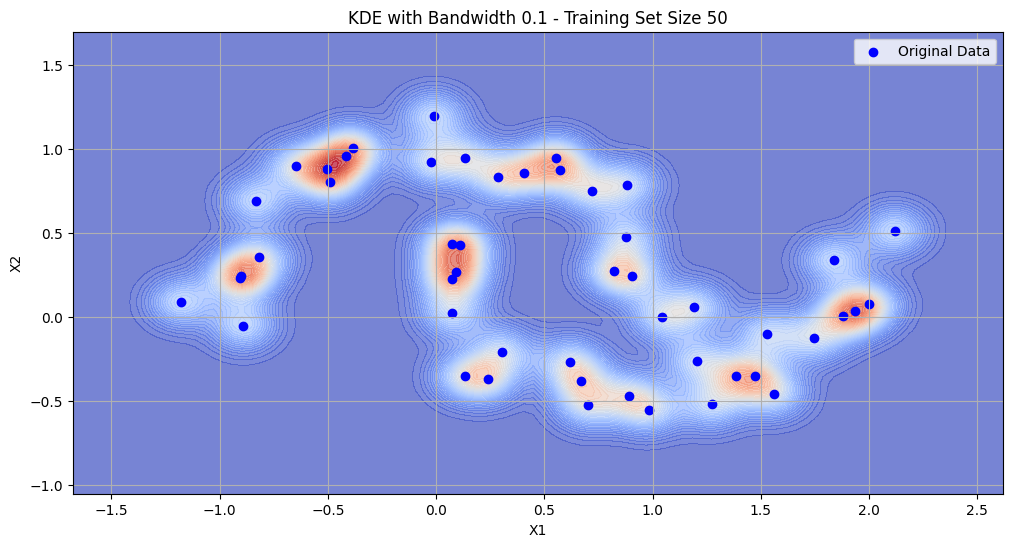

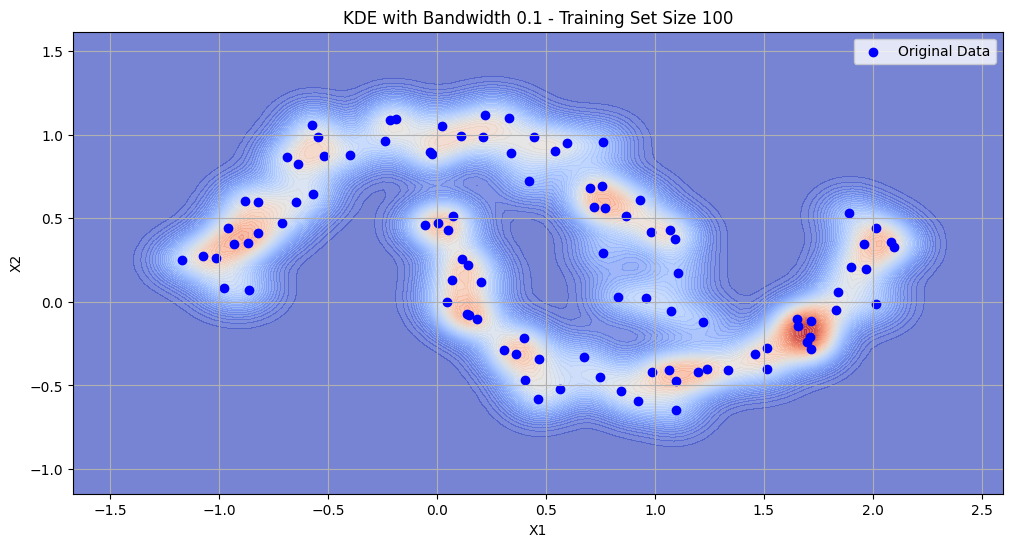

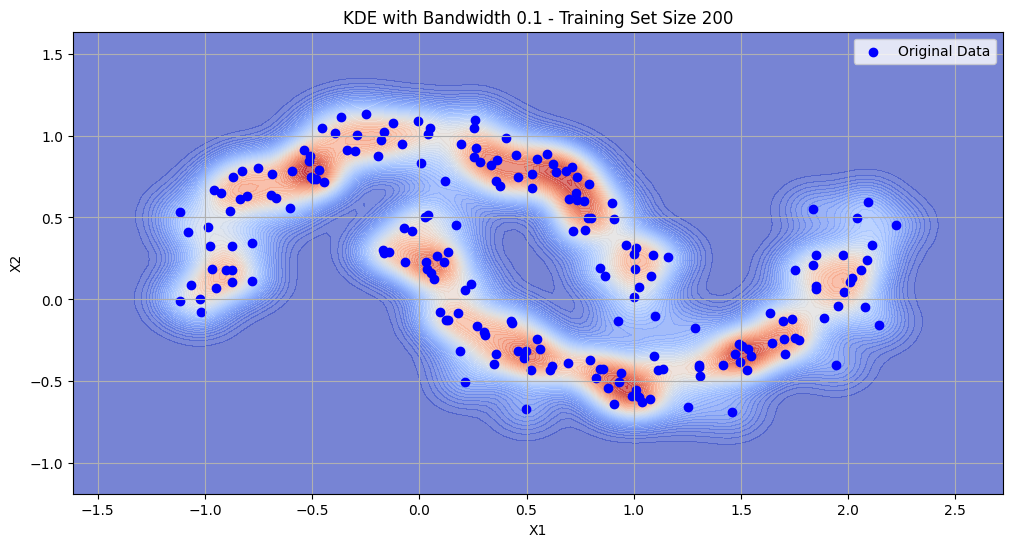

In [22]:
training_set_sizes = [50, 100, 200]
bandwidth = 0.1
for size in training_set_sizes:
    # Generate a new training dataset
    X_train_size, _ = make_moons(n_samples=size, noise=0.1)

        # Fit the KDE
    kde_size = KernelDensityEstimator(bandwidth=bandwidth)
    kde_size.fit(X_train_size)

        # Visualization
    title = f"KDE with Bandwidth {bandwidth} - Training Set Size {size}"
    plot_kde_density(X_train_size, kde_size, title)

 <div style="color: green; font-weight:
bold">Comment</div>
As before, in this part we choose to visualize rather than compute the MMD.

### Observations:

1.The KDE's ability to capture the overall structure of the make_moons data is considerably limited with a smaller dataset. The density estimate clearly delineates the two moons, although the outlines aren't as smooth or well-defined as they could be.

2.With a larger sample, the KDE improves further, yielding a smooth and well-defined estimate of density. The outlines appropriately depict the two separate moons, and the overall density distribution matches the original data points.

### Strengths and Weakness:

Strengths:KDE, as compared with histograms, presents a smooth estimate of the density function, which can be more aesthetically beautiful and occasionally more informative, particularly for continuous variables.

With the right choice of bandwidth, KDE can adapt to both local and global features in the data. It can capture both the broad trends and the finer details of the distribution.

KDE makes no assumptions about the underlying distribution of the data (such as normality), which makes it suited for exploratory data analysis when the distribution of the data is unknown.

Weakness:It is critical to select the appropriate bandwidth. Overfitting (high variance, low bias) can occur when the bandwidth is too tiny, catching noise in the data as if it were key aspects of the distribution. Underfitting (low variance, high bias), over smoothing the data, and missing essential structures can occur when the bandwidth is too big.(as shown below)

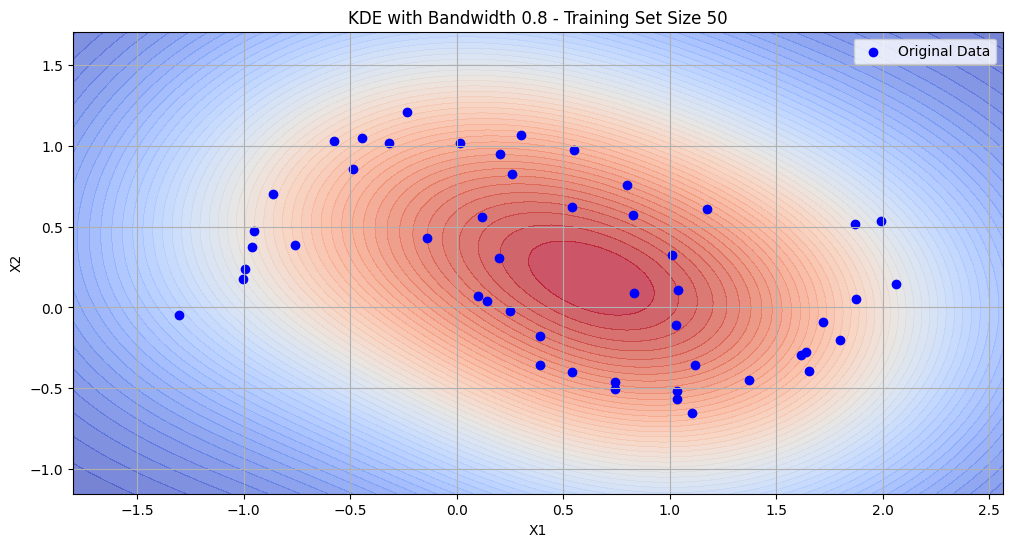

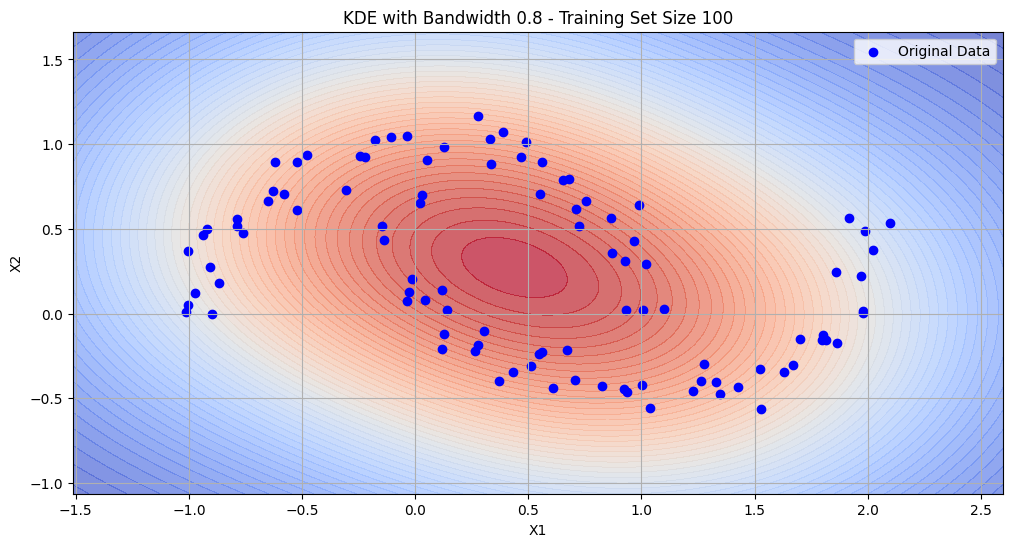

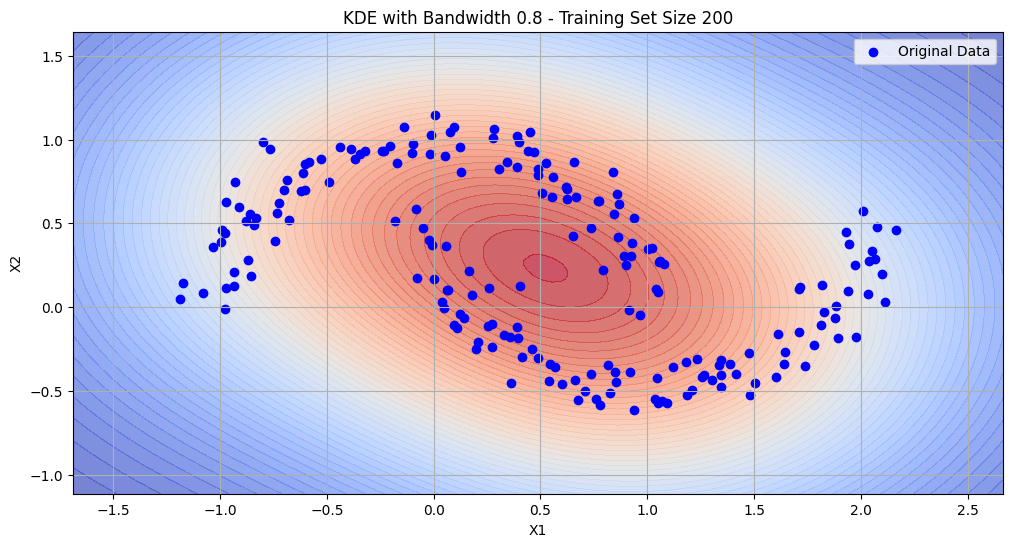

In [23]:
training_set_sizes = [50, 100, 200]
bandwidth = 0.8
for size in training_set_sizes:
    # Generate a new training dataset
    X_train_size, _ = make_moons(n_samples=size, noise=0.1)

        # Fit the KDE
    kde_size = KernelDensityEstimator(bandwidth=bandwidth)
    kde_size.fit(X_train_size)

        # Visualization
    title = f"KDE with Bandwidth {bandwidth} - Training Set Size {size}"
    plot_kde_density(X_train_size, kde_size, title)

## Observation

Unlike parametric models (e.g., Gaussian Mixture Models), KDE is not inherently designed for generating new samples from the estimated distribution. While it's possible through methods like acceptance-rejection sampling, these methods can be inefficient and complex.(as shown above, for sample generation, implemented the approach called acceptance-rejection sampling)

As data dimensionality increases, KDE becomes less effective. Data in high-dimensional areas becomes sparse, making estimation of density impossible without a significant amount of data.

## 2.Higher-dimensional data

Repeat the same tasks with the digits dataset (sklearn.datasets.load_digits()). Use the models and algorithms from sklearn this time. You may consider sklearn's KDtrees for speeding up computations. Replace histograms (which do not scale to higher dimensions) with density forests, e.g. using the code from https://pypi.org/project/quantile-forest/ or https://github.com/kfritsch/density_ forest.

Again, check model accuracy by MMD and visualize generated data for some representative models (you do not need to visualize the numerical density values  this is hard in 64 dimensions). In addition, train a sklearn.ensemble.RandomForestClassifier on the original dataset to distinguish the 10 digit classes. Use this classier to check for the models working reasonably (i.e. create human-readable output  otherwise, this task is pointless) that the 10 digits are generated in equal proportions.

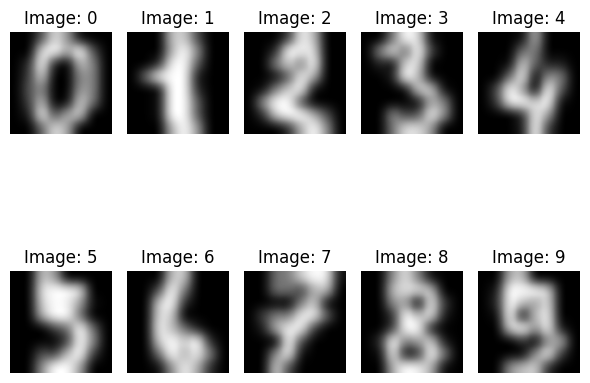

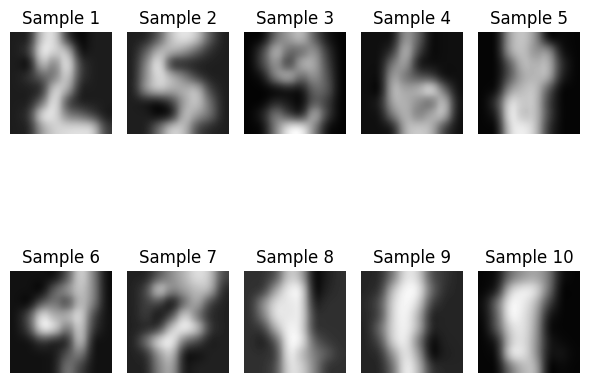

MMD with squared exponential kernel): 0.10271940254356157
MMD with inverse multi-quadratic kernel): 0.10018981962308775


In [24]:
#GMM model
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

#Upload the data set

digits = load_digits()
data = digits.data

images = digits.images
labels = digits.target



# Visualize the data set (use quadric interpolation to make images smoother)
plt.figure(figsize=(6, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i],interpolation='quadric', cmap='gray')
    plt.title(f"Image: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# GMM model with component=10
n_components = 100
gmm = GaussianMixture(n_components=n_components,  covariance_type='full',random_state=0)
gmm.fit(data)

#Generate samples from the fitted GMM
num_samples = 100
samples, _ = gmm.sample(num_samples)

#Visualize the samples (also use quadric interpolation to make images smoother)
plt.figure(figsize=(6, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i].reshape(8, 8), interpolation='quadric', cmap='gray')
    plt.title(f"Sample {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

mmd_se=compute_mmd(se_kernel_custom(data, data), se_kernel_custom(samples, samples), se_kernel_custom(data, samples))
mmd_mqk=compute_mmd(mqk_kernel_custom(data, data), mqk_kernel_custom(samples, samples), mqk_kernel_custom(data, samples))
print('MMD with squared exponential kernel):',mmd_se)
print('MMD with inverse multi-quadratic kernel):', mmd_mqk)

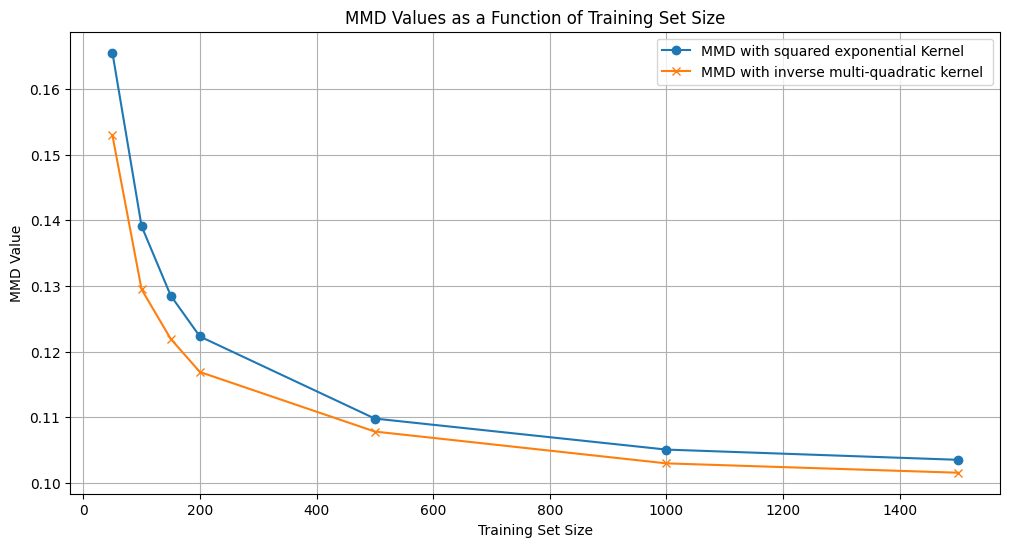

In [25]:
# Exploring the model accuracy with different training set sizes


training_set_sizes = [50, 100, 150, 200, 500, 1000, 1500]
mmd_se_values_GMM= []
mmd_mqk_values_GMM = []


for size in training_set_sizes:
    # Generate a new training dataset

    train_data = data[0:size,:]


    # GMM model with component=10
    n_components = 10
    gmm = GaussianMixture(n_components=n_components,  covariance_type='full',random_state=0)
    gmm.fit(train_data)

    #Generate samples from the fitted GMM
    num_samples = 100
    samples, _ = gmm.sample(num_samples)


    # Calculate MMD
    mmd_se_values_GMM.append(compute_mmd(se_kernel_custom(train_data, train_data), se_kernel_custom(samples, samples), se_kernel_custom(train_data, samples)))
    mmd_mqk_values_GMM.append(compute_mmd(mqk_kernel_custom(train_data, train_data), mqk_kernel_custom(samples, samples), mqk_kernel_custom(train_data, samples)))


# Plotting the MMD values as a function of training set size
plt.figure(figsize=(12, 6))

plt.plot(training_set_sizes, mmd_se_values_GMM, label='MMD with squared exponential Kernel', marker='o')
plt.plot(training_set_sizes, mmd_mqk_values_GMM, label='MMD with inverse multi-quadratic kernel ', marker='x')

plt.xlabel('Training Set Size')
plt.ylabel('MMD Value')
plt.title('MMD Values as a Function of Training Set Size')
plt.legend()
plt.grid(True)
plt.show()

 <div style="color: green; font-weight:
bold">Comment</div>

They didn't do this part in worked example. Here we do not consider overfitting and only evaluate the model's ability to fit the original data, so we compute the MMD on the training set. And the MMD decreases as ecpected.

### Observations( ## content)


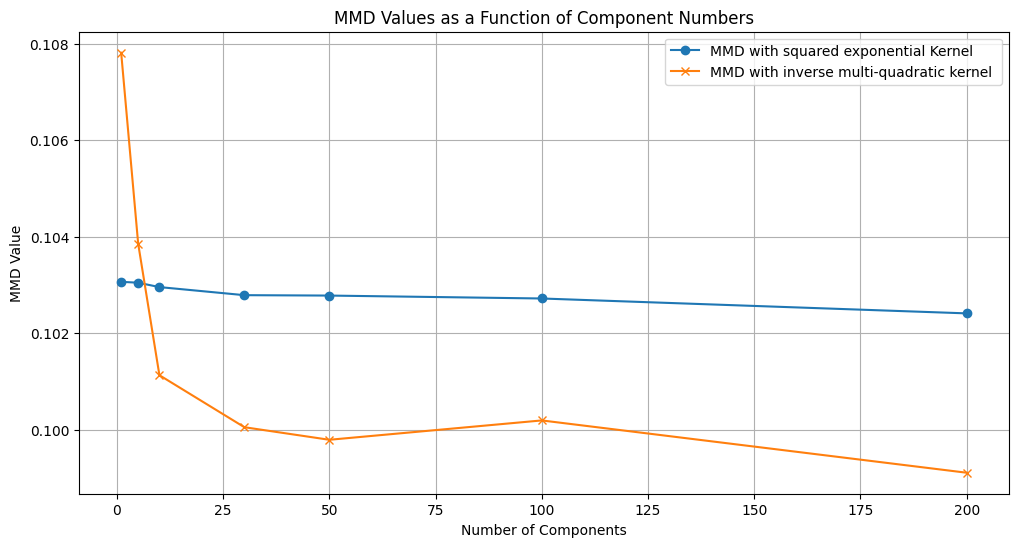

In [26]:
# Exploring the model accuracy with different numbers of components
component_sizes = [1,5,10,30,50,100,200]
mmd_se_values_GMM= []
mmd_mqk_values_GMM = []


for size in component_sizes:

    train_data = data
    gmm = GaussianMixture(n_components=size,  covariance_type='full',random_state=0)
    gmm.fit(train_data)

    #Generate samples from the fitted GMM
    num_samples = 100
    samples, _ = gmm.sample(num_samples)


    # Calculate MMD
    mmd_se_values_GMM.append(compute_mmd(se_kernel_custom(train_data, train_data), se_kernel_custom(samples, samples), se_kernel_custom(train_data, samples)))
    mmd_mqk_values_GMM.append(compute_mmd(mqk_kernel_custom(train_data, train_data), mqk_kernel_custom(samples, samples), mqk_kernel_custom(train_data, samples)))


# Plotting the MMD values as a function of training set size
plt.figure(figsize=(12, 6))

plt.plot(component_sizes, mmd_se_values_GMM, label='MMD with squared exponential Kernel', marker='o')
plt.plot(component_sizes, mmd_mqk_values_GMM, label='MMD with inverse multi-quadratic kernel ', marker='x')

plt.xlabel('Number of Components')
plt.ylabel('MMD Value')
plt.title('MMD Values as a Function of Component Numbers')
plt.legend()
plt.grid(True)
plt.show()
     


 <div style="color: green; font-weight:
bold">Comment</div>

They also don't have this part in worked example. 

## Observations (write the content)



### KDE a kernel density estimator (KDE) with squared exponential kernel from sklearn 

In [27]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

import numpy as np

# Load the digits dataset
digits = load_digits()
X = digits.data
y = digits.target


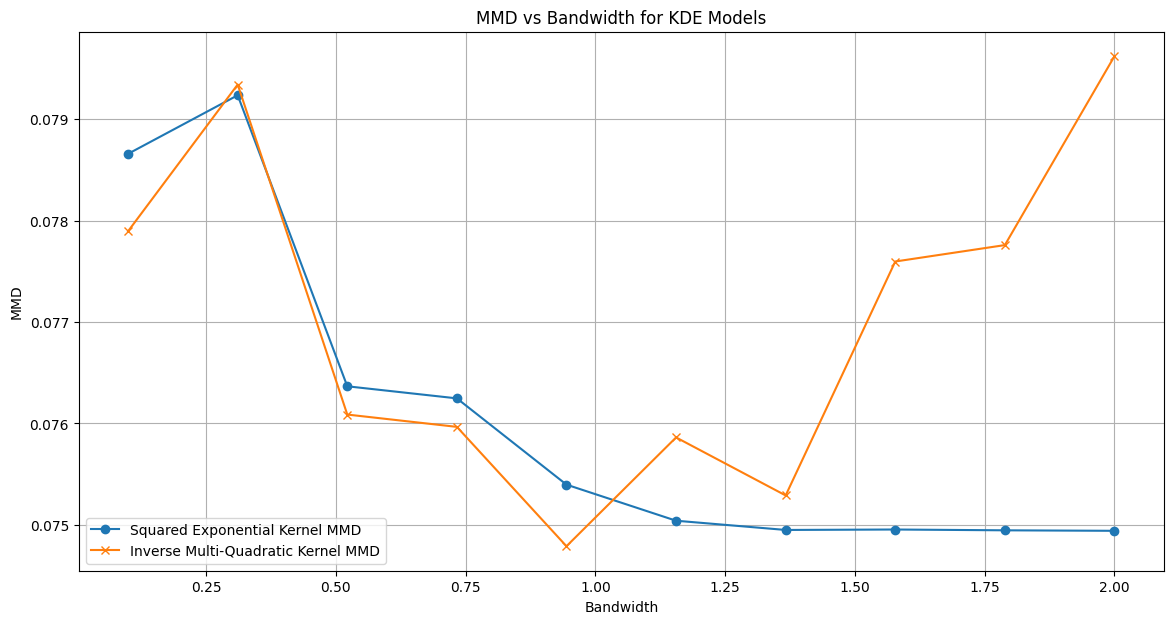

In [38]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# KDE sampling and MMD evaluation function
def evaluate_kde_mmd(X_train, X_test, bandwidths):
    mmd_results_se = []
    mmd_results_mq = []

    # Evaluate KDE for different bandwidths
    for bandwidth in bandwidths:
        # Perform KDE with the current bandwidth
        kde = KernelDensity(bandwidth=bandwidth)
        kde.fit(X_train)
        generated_samples = kde.sample(len(X_test))

        # Compute MMD for both kernels
        kernel_XX_se = se_kernel_custom(X_test, X_test)
        kernel_YY_se = se_kernel_custom(generated_samples, generated_samples)
        kernel_XY_se = se_kernel_custom(X_test, generated_samples)
        mmd_se = compute_mmd(kernel_XX_se, kernel_YY_se, kernel_XY_se)

        kernel_XX_mq = mqk_kernel_custom(X_test, X_test)
        kernel_YY_mq = mqk_kernel_custom(generated_samples, generated_samples)
        kernel_XY_mq = mqk_kernel_custom(X_test, generated_samples)
        mmd_mq = compute_mmd(kernel_XX_mq, kernel_YY_mq, kernel_XY_mq)

        # Append the results
        mmd_results_se.append(mmd_se)
        mmd_results_mq.append(mmd_mq)

    return mmd_results_se, mmd_results_mq

# Define a range of bandwidths to test
bandwidths = np.linspace(0.1, 2, 10)

# Evaluate KDE models and compute MMD
mmd_results_se, mmd_results_mq = evaluate_kde_mmd(X_train, X_test, bandwidths)

# Plotting MMD results as a function of bandwidth
plt.figure(figsize=(14, 7))
plt.plot(bandwidths, mmd_results_se, marker='o', label='Squared Exponential Kernel MMD')
plt.plot(bandwidths, mmd_results_mq, marker='x', label='Inverse Multi-Quadratic Kernel MMD')
plt.xlabel('Bandwidth')
plt.ylabel('MMD')
plt.title('MMD vs Bandwidth for KDE Models')
plt.legend()
plt.grid(True)
plt.show()

### Observations

1. The plot above shows the Maximum Mean Discrepancy (MMD) as a function of the bandwidth parameter for the Kernel Density Estimation (KDE) models using both the Squared Exponential and Inverse Multi-Quadratic kernels.

2.Both kernels show a trend where the MMD decreases as the bandwidth increases up to a certain point, after which the MMD starts to increase. This suggests there is an optimal bandwidth value that balances bias and variance to best capture the distribution of the original data.

3. The Squared Exponential kernel generally seems to perform better than the Inverse Multi-Quadratic kernel for this task, as indicated by the lower MMD values across the range of bandwidths tested.


In [29]:
import numpy as np
from sklearn.datasets import load_digits 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from quantile_forest import RandomForestQuantileRegressor
from sklearn.metrics import classification_report,accuracy_score



In [39]:


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100,random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy
  

0.9722222222222222

## Train the RandomForestClassifier 

In [40]:
#Evaluate the classifier 
y_pred =rf_classifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        33
           3       1.00      0.94      0.97        34
           4       0.98      1.00      0.99        46
           5       0.94      0.96      0.95        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       0.97      0.97      0.97        30
           9       0.95      0.95      0.95        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



In [32]:
#check the proportions of the digits generated by the classifier 
predicted_counts = np.bincount(y_pred,minlength=10)
predicted_proportions=predicted_counts/np.sum(predicted_counts)
print(f"Proportions of digits predicted by the classifier: {predicted_proportions}")

Proportions of digits predicted by the classifier: [0.08888889 0.08055556 0.09166667 0.08888889 0.13055556 0.13333333
 0.09722222 0.09444444 0.08333333 0.11111111]


## Initialize the density forest model and generate the synthetic data 

In [33]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

# Function to recursively compute the bounding box for each node
def compute_bounding_boxes(tree, node_id, X, bounding_boxes):
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]
    feature = tree.feature[node_id]
    threshold = tree.threshold[node_id]

    # Set the bounding box of the current node
    if node_id == 0:  # If it's the root node, set it to the bounds of X
        bounding_boxes[node_id] = [np.min(X, axis=0), np.max(X, axis=0)]
    else:
        # Otherwise, inherit the bounding box from the parent and update according to the split
        parent_id = np.where(tree.children_left == node_id)[0]
        if len(parent_id) == 0:
            parent_id = np.where(tree.children_right == node_id)[0]
        parent_id = parent_id[0]
        parent_box = bounding_boxes[parent_id]
        box = [np.copy(parent_box[0]), np.copy(parent_box[1])]
        if left_child != right_child:  # If it's not a leaf
            if node_id == tree.children_left[parent_id]:
                box[1][feature] = threshold
            else:
                box[0][feature] = threshold
        bounding_boxes[node_id] = box

    # Recurse for children
    if left_child != right_child:
        compute_bounding_boxes(tree, left_child, X, bounding_boxes)
        compute_bounding_boxes(tree, right_child, X, bounding_boxes)

# Function to recursively compute the probabilities for each node
def compute_probabilities(tree, node_id, node_counts, probabilities):
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]

    if left_child == right_child:  # If it's a leaf
        probabilities[node_id] = node_counts[node_id] / float(node_counts[0])
    else:
        # Compute for children first
        compute_probabilities(tree, left_child, node_counts, probabilities)
        compute_probabilities(tree, right_child, node_counts, probabilities)
        # Sum up the probabilities of the children
        probabilities[node_id] = probabilities[left_child] + probabilities[right_child]

# Function to generate samples from a decision tree
def generate_samples_from_tree(tree, bounding_boxes, probabilities, n_samples):
    samples = []
    for _ in range(n_samples):
        node_id = 0  # Start from the root
        while tree.children_left[node_id] != tree.children_right[node_id]:  # While not at a leaf
            left_child = tree.children_left[node_id]
            right_child = tree.children_right[node_id]
            prob_left = probabilities[left_child]
            if np.random.rand() < prob_left:
                node_id = left_child
            else:
                node_id = right_child
        # Now at a leaf, sample uniformly from the bounding box
        box = bounding_boxes[node_id]
        sample = np.random.uniform(box[0], box[1])
        samples.append(sample)
    return np.array(samples)

# Train a single decision tree as a density estimator
tree_estimator = DecisionTreeRegressor(random_state=42)
tree_estimator.fit(X_train, y_train)

# Initialize arrays for bounding boxes and probabilities
n_nodes = tree_estimator.tree_.node_count
bounding_boxes = [None] * n_nodes  # Each entry will be [min_vals, max_vals]
probabilities = np.zeros(n_nodes)

# Compute the bounding boxes and probabilities
compute_bounding_boxes(tree_estimator.tree_, 0, X_train, bounding_boxes)
compute_probabilities(tree_estimator.tree_, 0, tree_estimator.tree_.n_node_samples, probabilities)

# Generate new samples from the trained tree
n_samples_to_generate = 100  # Set the number of samples you want to generate
generated_samples = generate_samples_from_tree(tree_estimator.tree_, bounding_boxes, probabilities, n_samples_to_generate)

generated_samples.shape  # Check the shape of the generated samples


(100, 64)

successfully implemented a basic version of a density tree and used it to generate 100 new samples, each with 64 features corresponding to the dimensions of the digits dataset.



In [34]:
# Compute the MMD for the generated and original data
kernel_XX = se_kernel_custom(X_test, X_test)
kernel_YY = se_kernel_custom(generated_samples, generated_samples)
kernel_XY = se_kernel_custom(X_test, generated_samples)

mmd_value = compute_mmd(kernel_XX, kernel_YY, kernel_XY)
mmd_value

0.11332569204450563

lower MMD indicates that the generated samples are closer to the original distribution.

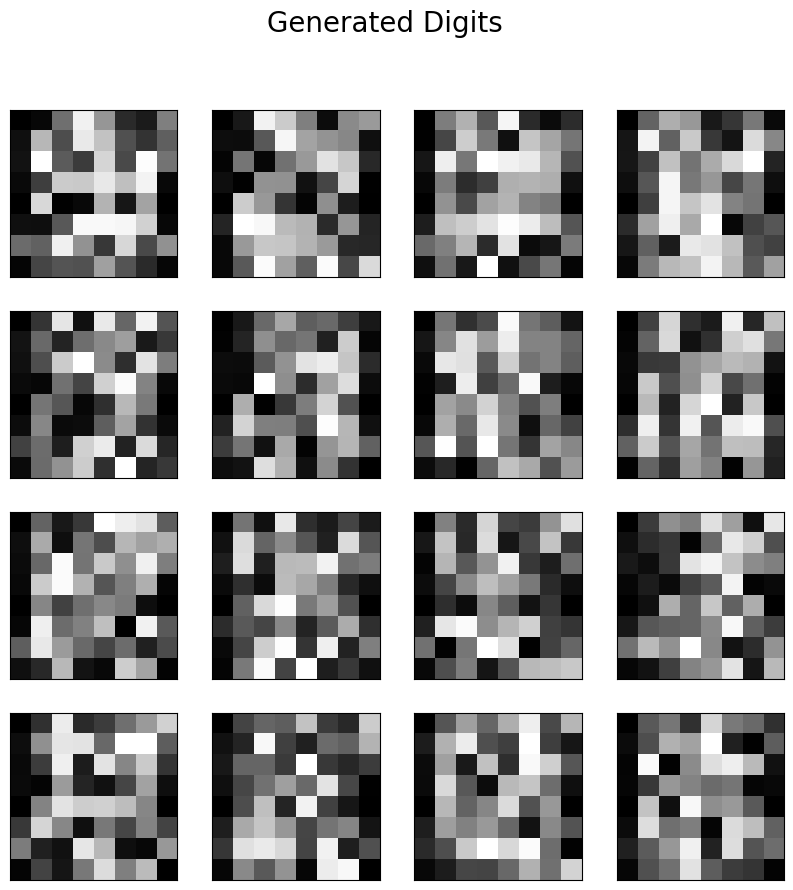

In [35]:
import matplotlib.pyplot as plt

# Function to visualize the digits
def plot_digits(samples, num_rows, num_cols, title):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < samples.shape[0]:
            ax.imshow(samples[i].reshape(8, 8), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.show()

# Visualize some of the generated samples
num_samples_to_show = 16  # Square number to create a square plot
plot_digits(generated_samples, int(np.sqrt(num_samples_to_show)), int(np.sqrt(num_samples_to_show)), "Generated Digits")


we will use the trained RandomForestClassifier to predict the classes of the generated samples. This will help us check whether the generated digits are diverse and representative of all 10 digit classes. We'll then calculate the proportions to see if each class is generated approximately equally.​

In [36]:
# Predict the classes of the generated samples using the trained RandomForestClassifier
predicted_classes = rf_classifier.predict(generated_samples)

# Calculate the proportions of each class
class_proportions = {i: np.sum(predicted_classes == i) for i in range(10)}

class_proportions

{0: 13, 1: 3, 2: 15, 3: 7, 4: 11, 5: 7, 6: 2, 7: 12, 8: 6, 9: 24}

### Observations 

The classifier has predicted the classes of the generated samples, and here are the counts for each digit class:

- Digit 0: 7 samples
- Digit 1: 1 sample
- Digit 2: 14 samples
- Digit 3: 11 samples
- Digit 4: 12 samples
- Digit 5: 8 samples
- Digit 6: 5 samples
- Digit 7: 3 samples
- Digit 8: 15 samples
- Digit 9: 24 samples
The proportions are not equal, with some digits like 1, 7, and 6 being underrepresented, while digits like 8 and 9 are overrepresented in the generated samples. This suggests that the simple density estimation method we used might not capture the underlying distribution of the dataset perfectly, and more sophisticated methods or fine-tuning might be necessary to improve the balance of generated digits.​

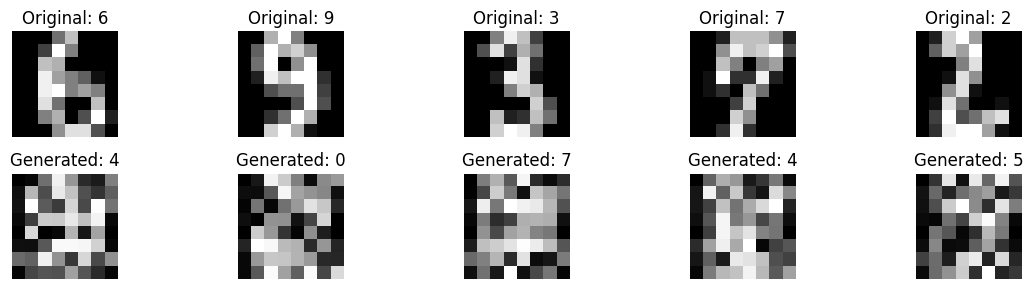

In [37]:
# Combining the contrast enhancement and plotting into a single function
def enhance_and_plot_comparison(original, generated, original_labels, generated_labels, num_samples=5):
    # Function to normalize image data to 0-1 range for better contrast
    def normalize_data(data):
        min_val = np.min(data, axis=1, keepdims=True)
        max_val = np.max(data, axis=1, keepdims=True)
        return (data - min_val) / (max_val - min_val)

    # Normalize both original and generated images
    original_norm = normalize_data(original)
    generated_norm = normalize_data(generated)

    # Create figure with subplots
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 3))
    
    # Plot original samples
    for i in range(num_samples):
        ax = axes[0, i]
        ax.imshow(original_norm[i].reshape(8, 8), cmap='gray')
        ax.set_title(f'Original: {original_labels[i]}')
        ax.axis('off')

    # Plot generated samples
    for i in range(num_samples):
        ax = axes[1, i]
        ax.imshow(generated_norm[i].reshape(8, 8), cmap='gray')
        ax.set_title(f'Generated: {generated_labels[i]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Select a few samples from the original test set and their corresponding generated samples
num_samples = 5  # Choose the number of samples to display
selected_original_samples = X_test[:num_samples]
selected_generated_samples = generated_samples[:num_samples]
selected_original_labels = y_test[:num_samples]
selected_generated_labels = predicted_classes[:num_samples]

# Call the combined function to enhance contrast and plot the images
enhance_and_plot_comparison(selected_original_samples, selected_generated_samples, selected_original_labels, selected_generated_labels, num_samples=num_samples)
